In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import sys
import tempfile
import pyabc

import healpy as hp
from scipy.special import sph_harm
import fitsio
from astropy.coordinates import SkyCoord
import astropy.units as u
import pandas as pd

sys.path.insert(0, '/home/aew492/lss-dipoles/code')
import tools
import dipole
import multipoles
from abc_for_qso import model, distance

### toy model

documentation: https://pyabc.readthedocs.io/en/latest/examples/parameter_inference.html

In [3]:
# simple Gaussian model, single parameter = mean (mu), fixed variance (0.5)
def Gaussian_model(parameter):
    return {"data": parameter["mu"] + 0.5 * np.random.randn()}

In [4]:
# uniform prior on mu from 0-5
prior = pyabc.Distribution(mu=pyabc.RV("uniform", 0, 5))  # note third argument is the _width_, not the upper bound

In [5]:
# distance between the simulated and real data: in this case, the absolute difference
def distance(x, x0):
    return abs(x["data"] - x0["data"])

From the documentation:

Now we create the ABCSMC object, the main inference class. It defines an ABC-SMC algorithm, which sequentially generates particle populations of size $N$, sampling in generation $t$ from a perturbation of accepted particles in generation $t-1$ via importance samling, thus from a successively improved posterior approximation, thus allowing to gradually reduce an acceptance threshold $\varepsilon$ on the permitted distance, while maintaining high acceptance rates.

In [9]:
# now create the ABCSMC object: generates populations of size N by randomly sampling from the prior
abc = pyabc.ABCSMC(Gaussian_model, prior, distance, population_size=1000)

ABC.Sampler INFO: Parallelize sampling on 48 processes.


In [10]:
# specify where to log the ABC-SMC runs (pyABC uses an SQL database (?))
db_path = os.path.join(tempfile.gettempdir(), "test.db")
observation = 2.5 # the REAL data -> if we observed a value of mu=2.5
abc.new("sqlite:///" + db_path, {"data": observation})

ABC.History INFO: Start <ABCSMC id=2, start_time=2024-12-27 17:10:24>


In [11]:
# start the sampling: sample until the acceptance threshold drops below 0.1, and specify a max of 10 populations
# *whichever is reached first, the acceptance threshold drops below 0.1, or the max populations, will stop the sampling
history = abc.run(minimum_epsilon=0.1, max_nr_populations=10)

ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 1.28257158e+00.
ABC INFO: Accepted: 1000 / 2060 = 4.8544e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 6.53987414e-01.
ABC INFO: Accepted: 1000 / 2340 = 4.2735e-01, ESS: 9.6058e+02.
ABC INFO: t: 2, eps: 3.23382261e-01.
ABC INFO: Accepted: 1000 / 3161 = 3.1636e-01, ESS: 7.6675e+02.
ABC INFO: t: 3, eps: 1.60941341e-01.
ABC INFO: Accepted: 1000 / 5837 = 1.7132e-01, ESS: 7.2561e+02.
ABC INFO: t: 4, eps: 7.99130842e-02.
ABC INFO: Accepted: 1000 / 11882 = 8.4161e-02, ESS: 7.5674e+02.
ABC INFO: Stop: Minimum epsilon.
ABC.History INFO: Done <ABCSMC id=2, duration=0:00:30.613469, end_time=2024-12-27 17:10:55>


In [40]:
Pop = history.get_population()
print(len(Pop)) # number of accepted
# get one particle
part = Pop.particles[0]
part.sum_stat['data']

1000


2.5564913700328344

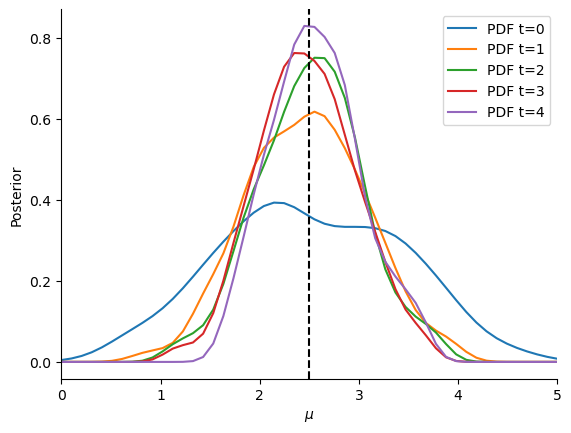

In [41]:
# visualize the results
pyabc.settings.set_figure_params('pyabc')  # for beautified plots

fig, ax = plt.subplots()
for t in range(history.max_t + 1):
    df, w = history.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(
        df,
        w,
        xmin=0,
        xmax=5,
        x="mu",
        xname=r"$\mu$",
        ax=ax,
        label=f"PDF t={t}",
    )
ax.axvline(observation, color="k", linestyle="dashed")
ax.legend()

## functions

In [3]:
def get_kde_1d(history, prior, parameter):
    df, w = history.get_distribution()
    return pyabc.visualization.kde.kde_1d(pd.concat((df[parameter],), axis=1), w, df[parameter].name,
                           xmin=prior[parameter][0],
                           xmax=prior[parameter][0] + prior[parameter][1])

In [4]:
def get_kde_2d(history, prior, parameter1, parameter2):
    df, w = history.get_distribution()
    return pyabc.visualization.kde.kde_2d(pd.concat((df[parameter1], df[parameter2]), axis=1), w, df[parameter1].name, df[parameter2].name,
                            xmin=prior[parameter1][0],
                            xmax=prior[parameter1][0] + prior[parameter1][1],
                            ymin=prior[parameter2][0],
                            ymax=prior[parameter2][0] + prior[parameter2][1])

In [5]:
def scatter(history, prior, parameter1, parameter2, ax, **kwargs):
    df, w = history.get_distribution()
    ax.scatter(df[parameter1], df[parameter2], **kwargs)
    ax.set_xlim(prior[parameter1][0],
                prior[parameter1][0] + prior[parameter1][1])
    ax.set_ylim(prior[parameter2][0],
                prior[parameter2][0] + prior[parameter2][1])

## a simple model

Imagine the data is dipole + shot noise, galactic plane mask, and we want to infer the dipole amplitude.

In [10]:
def model(parameters):
    """
    Generates a healpix density map with dipole in fixed CMB dipole direction.

    Parameters
    ----------
    parameters : dict
        keys:
            "dipole_amp" = dipole amplitude
            "base_rate" = quasar density base rate

    Returns
    -------
    Quasar overdensity map of NSIDE=1.
    
    """
    
    rng = np.random.default_rng(seed=None) # should I put a seed in here??
    blim = 30
    nside = 1

    # expected dipole map
    amps = np.zeros(4)
    amps[1:] = cmb_dipole(amplitude=parameters["dipole_amp"], return_amps=True)
    expected_dipole_map = dipole_map(amps, NSIDE=nside)

    # galactic plane mask
    mask = tools.get_galactic_plane_mask(blim, nside=64, frame='icrs')
    mask_dg = hp.ud_grade(mask, nside)

    # poisson sample, including the base rate and the selfunc map
    overdensity_map = rng.poisson((1. + expected_dipole_map) * parameters["base_rate"] * mask_dg)

    return { "data" : overdensity_map }

In [14]:
# construct "real" data
nside = 64
base_rate = 33.64
amps = np.array([0., *cmb_dipole(amplitude=0.0052, return_amps=True)])
rng = np.random.default_rng(seed=None)
qmap = rng.poisson((1. + dipole_map(amps, NSIDE=nside)) * base_rate * tools.get_galactic_plane_mask(30, nside=nside, frame='icrs'))
qmap_dg = hp.ud_grade(qmap, 1, power=-2)

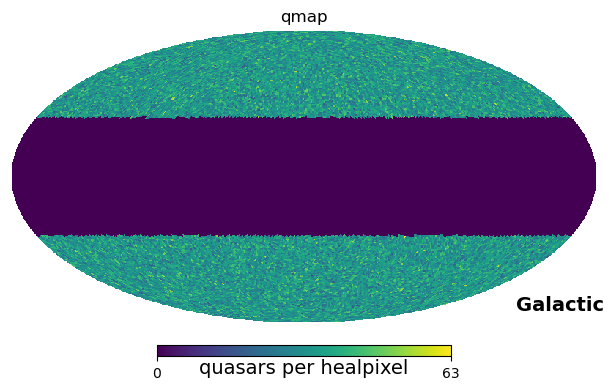

In [15]:
fig = plt.figure(figsize=(12,4))
hp.mollview(qmap, coord=['C','G'], sub=(1,2,1), unit='quasars per healpixel', title='qmap')

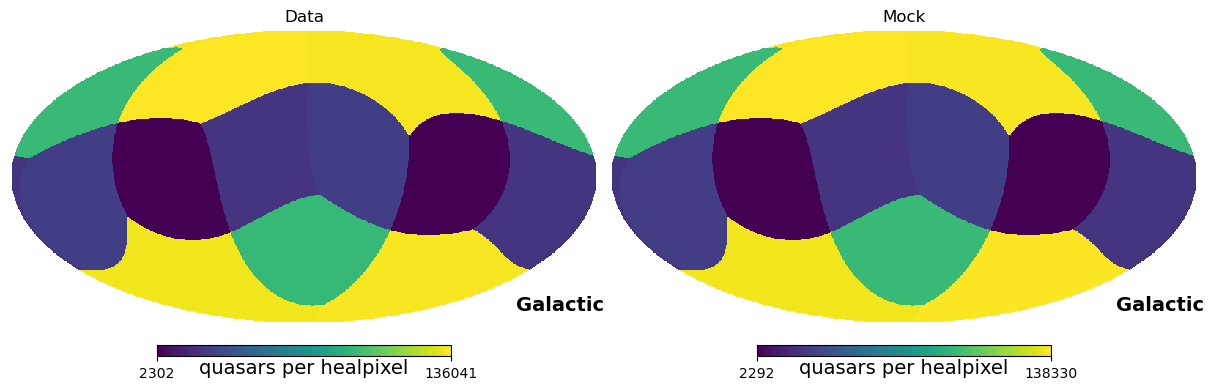

In [23]:
# compare real and example mock
mock = model(dict(dipole_amp=.004, base_rate=1.4e5))
fig = plt.figure(figsize=(12,4))
hp.mollview(qmap_dg, coord=['C','G'], sub=(1,2,1), unit='quasars per healpixel', title='Data')
hp.mollview(mock['data'], coord=['C','G'], sub=(1,2,2), unit='quasars per healpixel', title='Mock')

In [41]:
expected_dipole_amp = 0.0052
prior = pyabc.Distribution(dipole_amp = pyabc.RV("uniform", 0., 3 * expected_dipole_amp),
                           base_rate = pyabc.RV("uniform", 1.37e5, 2e3))  # note much higher base rate since healpixels are much bigger

In [42]:
def distance(x, x0):
    return sum((x["data"] - x0["data"])**2)

In [43]:
# perform the parameter inference
abc = pyabc.ABCSMC(model, prior, distance, population_size=100)

# history
db_path = os.path.join(tempfile.gettempdir(), "test.db")
observation = qmap_dg
abc.new("sqlite:///" + db_path, {"data": observation})

# start the sampling!
history = abc.run(minimum_epsilon=10, max_nr_populations=10)

ABC.Sampler INFO: Parallelize sampling on 48 processes.
ABC.History INFO: Start <ABCSMC id=3, start_time=2024-12-21 12:45:09>
ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 3.95601750e+06.
ABC INFO: Accepted: 100 / 202 = 4.9505e-01, ESS: 1.0000e+02.
ABC INFO: t: 1, eps: 2.07113100e+06.
ABC INFO: Accepted: 100 / 349 = 2.8653e-01, ESS: 9.4435e+01.
ABC INFO: t: 2, eps: 1.55424622e+06.
ABC INFO: Accepted: 100 / 376 = 2.6596e-01, ESS: 6.0973e+01.
ABC INFO: t: 3, eps: 1.19159760e+06.
ABC INFO: Accepted: 100 / 891 = 1.1223e-01, ESS: 2.3487e+01.
ABC INFO: t: 4, eps: 1.00732861e+06.
ABC INFO: Accepted: 100 / 914 = 1.0941e-01, ESS: 9.3903e+01.
ABC INFO: t: 5, eps: 8.13330667e+05.
ABC INFO: Accepted: 100 / 1155 = 8.6580e-02, ESS: 7.5057e+01.
ABC INFO: t: 6, eps: 6.76966740e+05.
ABC INFO: Accepted: 100 / 1955 = 5.1151e-02, ESS: 8.0472e+01.
ABC INFO: t: 7, eps: 5.09561286e+05.
ABC INFO: Accepted: 100 / 4775 = 2.0942e-02, ESS: 4.8033e+01.
ABC INFO: t: 8, eps: 3.84629658e+05.
ABC INFO: Acc

Text(0.5, 1.02, 'ABC posteriors: "data" = 0.0052 dipole amp, no excess power')

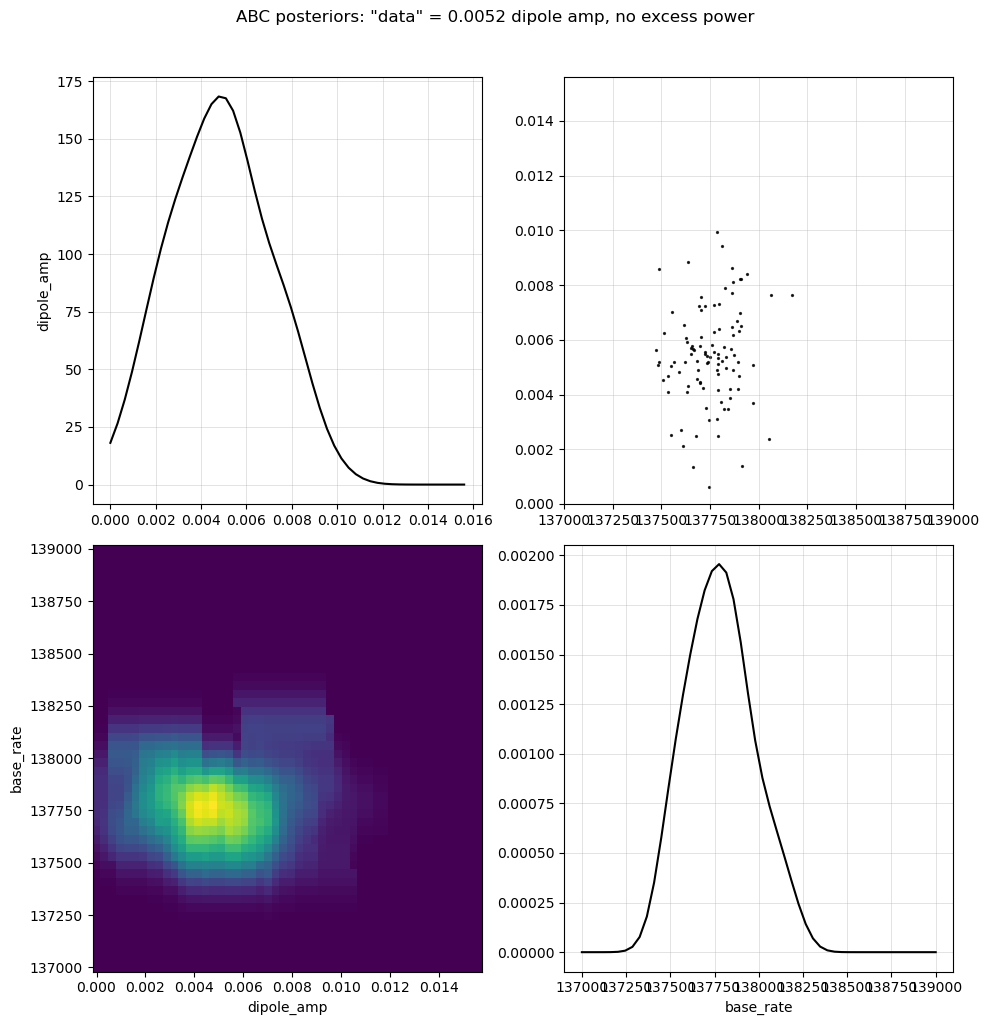

In [49]:
# plot (copied and adjusted from the pyabc.visualization source code)
par_ids = ["dipole_amp", "base_rate"]
fig, axs = plt.subplots(len(par_ids), len(par_ids), figsize=(10,10), tight_layout=True)
df, w = history.get_distribution()

for i in range(len(par_ids)):

    # diagonal
    ax = axs[i, i]
    x, pdf = get_kde_1d(abc, par_ids[i])
    ax.plot(x, pdf, c='k')
    ax.grid(alpha=0.5, lw=0.5)

    axs[i,0].set_ylabel(par_ids[i])
    axs[len(par_ids)-1,i].set_xlabel(par_ids[i])

    for j in range(0, i):

        # lower
        ax = axs[i, j]
        x, y, pdf = get_kde_2d(abc, par_ids[j], par_ids[i])
        mesh = ax.pcolormesh(x, y, pdf, shading='auto')

        # upper
        ax = axs[j, i]
        scatter(abc, par_ids[i], par_ids[j], ax, color='k', alpha=0.8, marker='.', s=7)
        ax.grid(alpha=0.5, lw=0.5)
        
fig.suptitle(f'ABC posteriors: "data" = {expected_dipole_amp} dipole amp, no excess power', y=1.02)

## our model with Quaia!

#### test downgrading

In [66]:
# selection function
selfunc = hp.read_map(f'/scratch/aew492/lss-dipoles_results/data/catalogs/quaia/selfuncs/selection_function_NSIDE64_G20.0.fits')

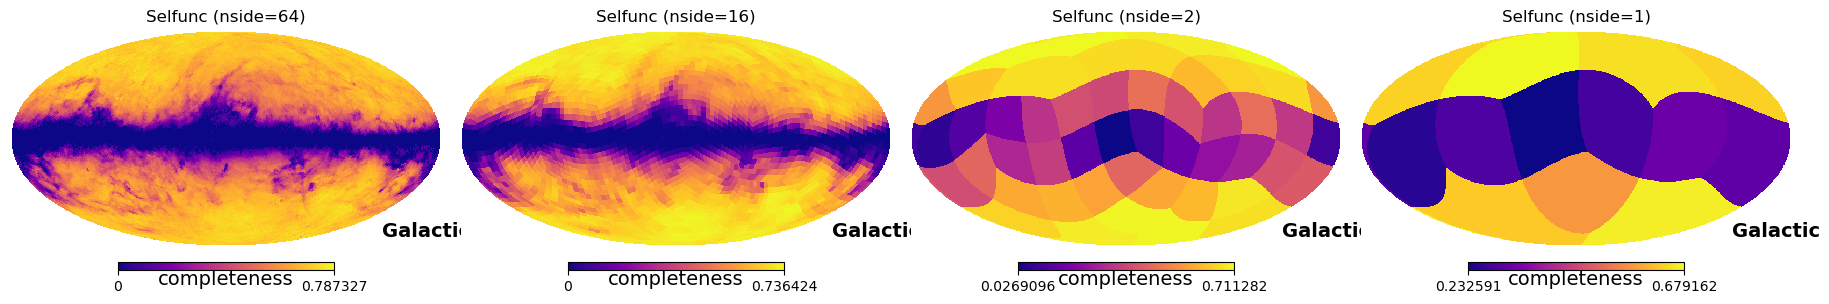

In [67]:
nsides = [16, 2, 1]
fig = plt.figure(figsize=(6*len(nsides),3), tight_layout=True)
hp.mollview(selfunc, coord=['C','G'], cmap='plasma', sub=(1,len(nsides)+1,1), title='Selfunc (nside=64)', unit='completeness')
for i, nside in enumerate(nsides):
    selfunc_dg = hp.pixelfunc.ud_grade(selfunc, nside)
    hp.mollview(selfunc_dg, coord=['C','G'], cmap='plasma', sub=(1,len(nsides)+1,i+2), title=f'Selfunc (nside={nside})', unit='completeness')

In [68]:
# masks
small_masks = fitsio.read(f'/scratch/aew492/lss-dipoles_results/data/catalogs/masks/mask_master_hpx_r1.0.fits')
mask = small_masks * tools.get_galactic_plane_mask(30, nside=hp.npix2nside(len(small_masks)), frame='icrs')

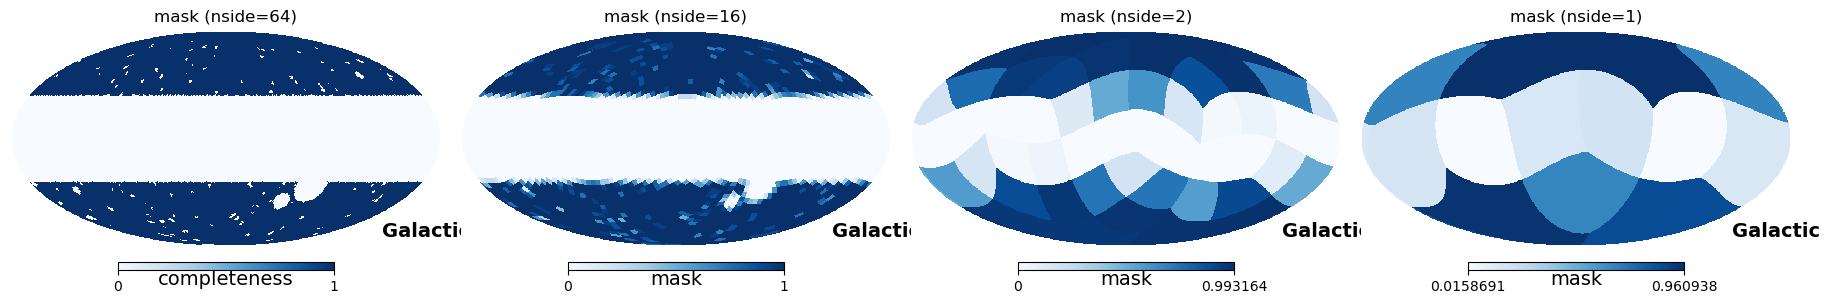

In [69]:
nsides = [16, 2, 1]
fig = plt.figure(figsize=(6*len(nsides),3), tight_layout=True)
hp.mollview(mask, coord=['C','G'], cmap='Blues', sub=(1,len(nsides)+1,1), title='mask (nside=64)', unit='completeness')
for i, nside in enumerate(nsides):
    mask_dg = hp.pixelfunc.ud_grade(mask, nside)
    hp.mollview(mask_dg, coord=['C','G'], cmap='Blues', sub=(1,len(nsides)+1,i+2), title=f'mask (nside={nside})', unit='mask')

In [70]:
small_masks = fitsio.read(f'/scratch/aew492/lss-dipoles_results/data/catalogs/masks/mask_master_hpx_r1.0.fits')
gal_plane_mask = tools.get_galactic_plane_mask(30, nside=64, frame='icrs')
selfunc_fn = f'/scratch/aew492/lss-dipoles_results/data/catalogs/quaia/selfuncs/selection_function_NSIDE64_G20.0.fits'
selfunc = hp.read_map(selfunc_fn) * small_masks * gal_plane_mask

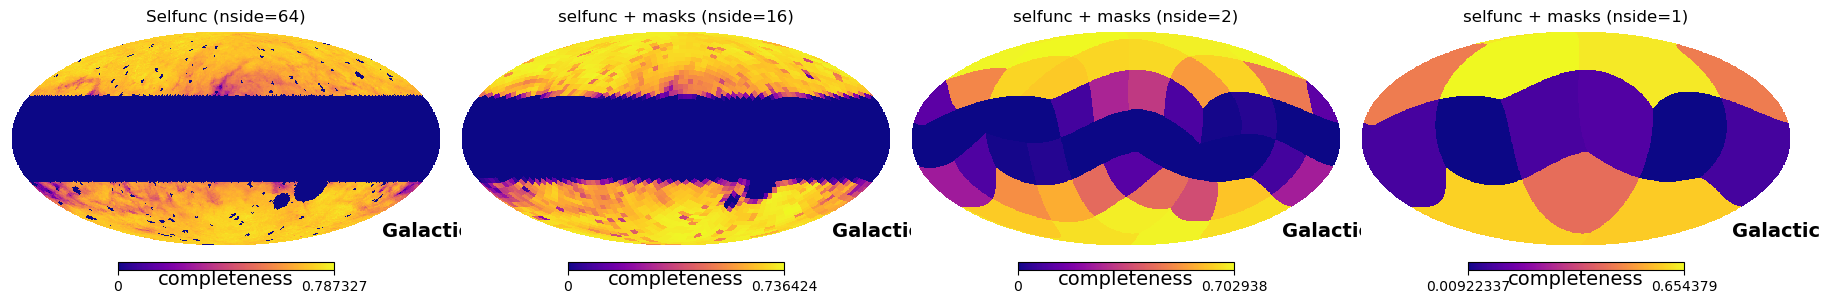

In [71]:
nsides = [16, 2, 1]
fig = plt.figure(figsize=(6*len(nsides),3), tight_layout=True)
hp.mollview(selfunc, coord=['C','G'], cmap='plasma', sub=(1,len(nsides)+1,1), title='Selfunc (nside=64)', unit='completeness')
for i, nside in enumerate(nsides):
    selfunc_dg = hp.pixelfunc.ud_grade(selfunc, nside)
    hp.mollview(selfunc_dg, coord=['C','G'], cmap='plasma', sub=(1,len(nsides)+1,i+2), title=f'selfunc + masks (nside={nside})', unit='completeness')

In [72]:
# okay the nside that we actually want to use for the sampling
nside = 64

In [73]:
# selection function
small_masks = fitsio.read(f'/scratch/aew492/lss-dipoles_results/data/catalogs/masks/mask_master_hpx_r1.0.fits')
selfunc_fn = f'/scratch/aew492/lss-dipoles_results/data/catalogs/quaia/selfuncs/selection_function_NSIDE64_G20.0.fits'
selfunc = hp.read_map(selfunc_fn) * small_masks * tools.get_galactic_plane_mask(30, nside=64, frame='icrs')
# downsample and add galactic plane mask
selfunc_dg = hp.pixelfunc.ud_grade(selfunc, nside)

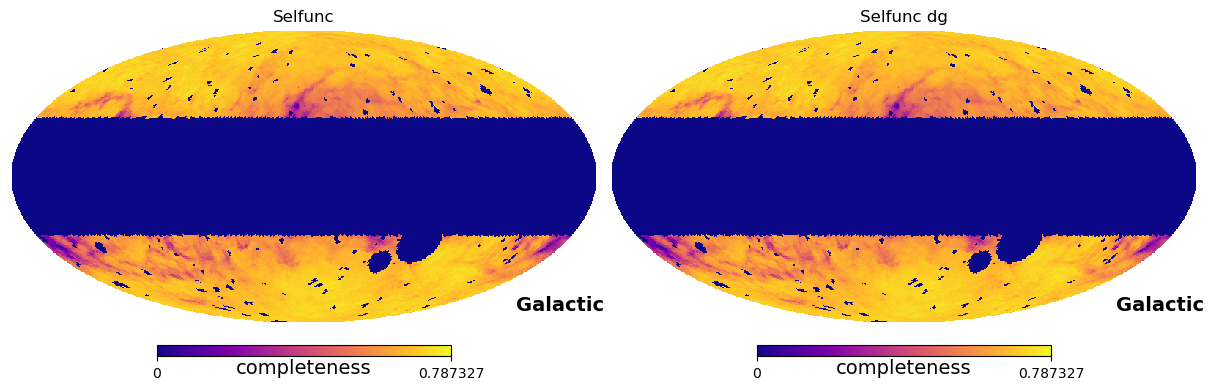

In [74]:
fig = plt.figure(figsize=(12,4))
hp.mollview(selfunc, coord=['C','G'], unit='completeness', title='Selfunc', cmap='plasma', sub=(1,2,1))
hp.mollview(selfunc_dg, coord=['C','G'], unit='completeness', title='Selfunc dg', cmap='plasma', sub=(1,2,2))

In [75]:
sum(selfunc), sum(selfunc_dg)

(15153.812230362631, 15153.812230362631)

#### define data, model, prior and distance

In [83]:
# data
fn_cat = f'/scratch/aew492/lss-dipoles_results/data/catalogs/quaia/quaia_G20.0.fits'
qmap_raw = tools.load_catalog_as_map(fn_cat, frame='icrs', nside=64)
# add galactic plane mask
qmap = qmap_raw * tools.get_galactic_plane_mask(30, nside=64, frame='icrs') * small_masks
qmap_dg = hp.ud_grade(qmap, nside, power=-2)  # power = -2 preserves the sum of the map / total number of quasars

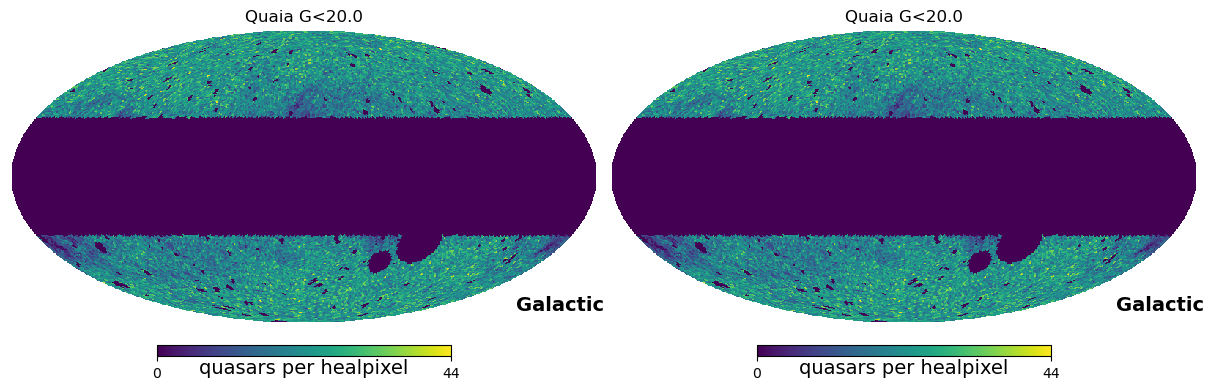

In [84]:
fig = plt.figure(figsize=(12,4))
hp.mollview(qmap, coord=['C','G'], unit='quasars per healpixel', title='Quaia G<20.0', sub=(1,2,1))
hp.mollview(qmap_dg, coord=['C','G'], unit='quasars per healpixel', title='Quaia G<20.0', sub=(1,2,2))

In [85]:
def quaia_model(parameters):
    """
    Generates a healpix density map with dipole in fixed CMB dipole direction.

    Parameters
    ----------
    parameters : dict
        keys:
            "dipole_amp" = dipole amplitude
            "log_excess" = log of the excess power (flat in Cell)
            "base_rate" = quasar density base rate

    Returns
    -------
    Quasar overdensity map of NSIDE=1.
    
    """
    
    rng = np.random.default_rng(seed=None) # should I put a seed in here??
    blim = 30

    # selection function
    small_masks = fitsio.read(f'/scratch/aew492/lss-dipoles_results/data/catalogs/masks/mask_master_hpx_r1.0.fits')
    selfunc_fn = f'/scratch/aew492/lss-dipoles_results/data/catalogs/quaia/selfuncs/selection_function_NSIDE64_G20.0.fits'
    selfunc = hp.read_map(selfunc_fn) * small_masks * tools.get_galactic_plane_mask(blim, nside=64, frame='icrs')
    # downsample
    selfunc_dg = hp.pixelfunc.ud_grade(selfunc, nside)

    # expected dipole map
    amps = np.zeros(4)
    amps[1:] = dipole.cmb_dipole(amplitude=parameters["dipole_amp"], return_amps=True)
    expected_dipole_map = dipole.dipole_map(amps, NSIDE=nside)

    # add Cells
    # Cells: flat, determined by input log_excess
    Cells = np.zeros(8) + 10**parameters["log_excess"]
    # draw alms from a Gaussian
    sph_harm_amp_dict = {}
    for ell in range(1, len(Cells)+1):
        sph_harm_amp_dict[ell] = np.sqrt(Cells[ell-1]) * rng.normal(size=2 * ell + 1)
    # then make map from the alms
    excess_map = np.zeros((hp.nside2npix(nside)))
    for ell in sph_harm_amp_dict.keys():
        alms = sph_harm_amp_dict[ell]
        assert len(alms) == 2 * ell + 1, \
            f"incorrect number of coefficients for ell={ell} ({len(alms)}, expected {2 * ell + 1}"
        excess_map += multipoles.multipole_map(alms, NSIDE=nside)

    # smooth overdensity map
    smooth_overdensity_map = expected_dipole_map + excess_map

    # poisson sample, including the base rate and the selfunc map
    overdensity_map = rng.poisson((1. + smooth_overdensity_map) * parameters["base_rate"] * selfunc_dg)

    return { "data" : overdensity_map }

In [86]:
expected_dipole_amp = 0.0052
dipole_amp_bounds = (0., 3 * expected_dipole_amp)
log_excess_bounds = (-6, 3)
base_rate_bounds = (32., 35.)
prior = pyabc.Distribution(dipole_amp = pyabc.RV("uniform", *dipole_amp_bounds),
                           log_excess = pyabc.RV("uniform", *log_excess_bounds),
                           base_rate = pyabc.RV("uniform", *base_rate_bounds))  # note much higher base rate since healpixels are much bigger

In [87]:
def distance(x, x0):
    #assert len(x["data"]) == len(x0["data"])
    #assert x["data"].ndim == x0["data"].ndim
    return sum((x["data"] - x0["data"])**2)

#### perform the parameter inference

In [88]:
abc = pyabc.ABCSMC(quaia_model, prior, distance, population_size=5)

ABC.Sampler INFO: Parallelize sampling on 48 processes.


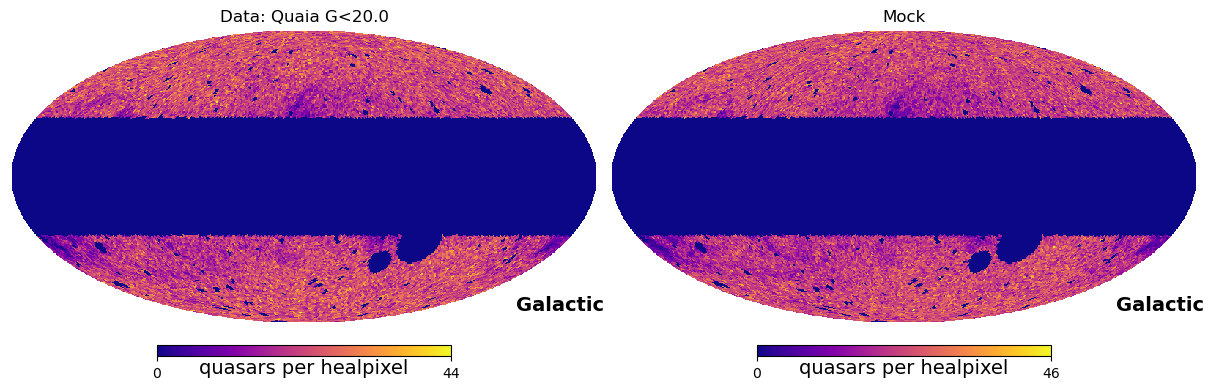

In [89]:
# compare data and mock as a sanity check
mock = quaia_model(dict(dipole_amp=0.0052, log_excess=-5, base_rate=34))["data"]
fig = plt.figure(figsize=(12,4), tight_layout=True)
hp.mollview(qmap_dg, coord=['C','G'], cmap='plasma', sub=(1,2,1), title='Data: Quaia G<20.0', unit='quasars per healpixel')
hp.mollview(mock, coord=['C','G'], cmap='plasma', sub=(1,2,2), title='Mock', unit='quasars per healpixel')

In [101]:
db_path = os.path.join(tempfile.gettempdir(), "test.db")
observation = qmap_dg
abc.new("sqlite:///" + db_path, {"data": observation})

ABC.History INFO: Start <ABCSMC id=8, start_time=2024-12-25 21:46:03>


In [ ]:
# start the sampling!
history = abc.run(minimum_epsilon=1000, max_nr_populations=8)

ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 4.07050400e+06.
ABC INFO: Accepted: 5 / 56 = 8.9286e-02, ESS: 5.0000e+00.
ABC INFO: t: 1, eps: 2.19562400e+06.
ABC INFO: Accepted: 5 / 55 = 9.0909e-02, ESS: 4.8525e+00.
ABC INFO: t: 2, eps: 1.50965612e+06.
ABC INFO: Accepted: 5 / 65 = 7.6923e-02, ESS: 4.3012e+00.
ABC INFO: t: 3, eps: 1.49482224e+06.


In [45]:
# 0:40 for Quaia nside=1, 10pop, 5gens
# 3:43 for Quaia nside=2, 50pop, 10gens

In [46]:
prior = dict(dipole_amp=(0., 3 * expected_dipole_amp),
             log_excess = (-6, 3),
             base_rate = (8.5e3, 5e2))

Text(0.5, 0.98, 'ABC posteriors')

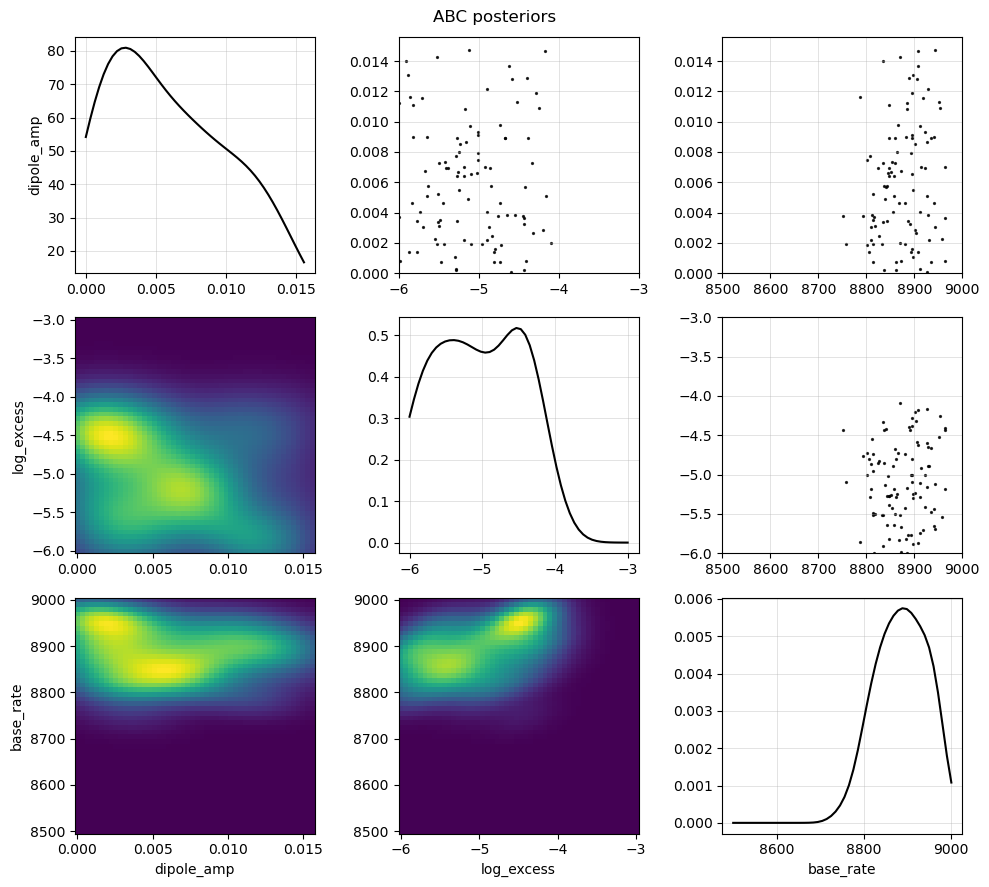

In [47]:
# plot (copied and adjusted from the pyabc.visualization source code)
par_ids = ['dipole_amp', 'log_excess', 'base_rate']
fig, axs = plt.subplots(len(par_ids), len(par_ids), figsize=(10,9), tight_layout=True)
df, w = history.get_distribution()

for i in range(len(par_ids)):

    # diagonal
    ax = axs[i, i]
    x, pdf = get_kde_1d(history, prior, par_ids[i])
    ax.plot(x, pdf, c='k')
    ax.grid(alpha=0.5, lw=0.5)

    axs[i,0].set_ylabel(par_ids[i])
    axs[len(par_ids)-1,i].set_xlabel(par_ids[i])

    for j in range(0, i):

        # lower
        ax = axs[i, j]
        x, y, pdf = get_kde_2d(history, prior, par_ids[j], par_ids[i])
        mesh = ax.pcolormesh(x, y, pdf, shading='auto')

        # upper
        ax = axs[j, i]
        scatter(history, prior, par_ids[i], par_ids[j], ax, color='k', alpha=0.8, marker='.', s=7)
        ax.grid(alpha=0.5, lw=0.5)
        
fig.suptitle(f'ABC posteriors')

Text(0.5, 0.98, 'ABC posteriors')

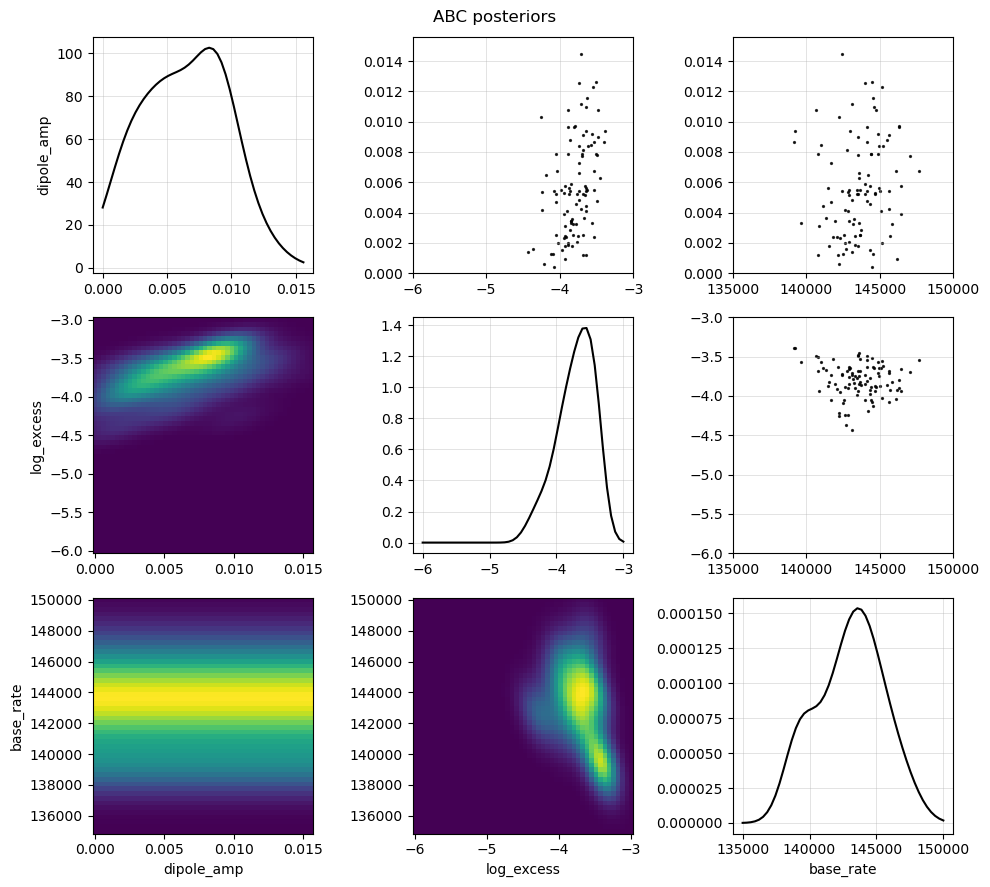

In [39]:
# plot (copied and adjusted from the pyabc.visualization source code)
par_ids = ['dipole_amp', 'log_excess', 'base_rate']
fig, axs = plt.subplots(len(par_ids), len(par_ids), figsize=(10,9), tight_layout=True)
df, w = history.get_distribution()

for i in range(len(par_ids)):

    # diagonal
    ax = axs[i, i]
    x, pdf = get_kde_1d(abc, par_ids[i])
    ax.plot(x, pdf, c='k')
    ax.grid(alpha=0.5, lw=0.5)

    axs[i,0].set_ylabel(par_ids[i])
    axs[len(par_ids)-1,i].set_xlabel(par_ids[i])

    for j in range(0, i):

        # lower
        ax = axs[i, j]
        x, y, pdf = get_kde_2d(abc, par_ids[j], par_ids[i])
        mesh = ax.pcolormesh(x, y, pdf, shading='auto')

        # upper
        ax = axs[j, i]
        scatter(abc, par_ids[i], par_ids[j], ax, color='k', alpha=0.8, marker='.', s=7)
        ax.grid(alpha=0.5, lw=0.5)
        
fig.suptitle(f'ABC posteriors')

/ext3/miniconda3/lib/python3.10/site-packages/healpy/visufunc.py:332: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pylab.draw()
/ext3/miniconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


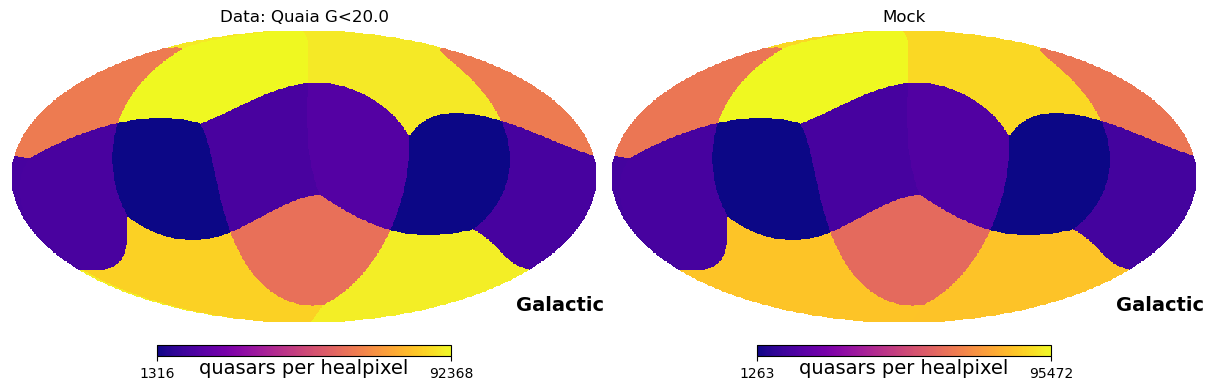

In [69]:
# pull an accepted mock and compare to the input data:
mock_pars = history.get_distribution()[0].iloc[0] # just get the first row of the data frame
mock_map = model(dict(dipole_amp=mock_pars['dipole_amp'], log_excess=mock_pars['log_excess'], base_rate=mock_pars['base_rate']))['data']
fig = plt.figure(figsize=(12,4), tight_layout=True)
hp.mollview(qmap_dg, coord=['C','G'], cmap='plasma', sub=(1,2,1), title='Data: Quaia G<20.0', unit='quasars per healpixel')
hp.mollview(mock_map, coord=['C','G'], cmap='plasma', sub=(1,2,2), title='Mock', unit='quasars per healpixel')

Text(0.5, 1.0, 'Epsilon evolution')

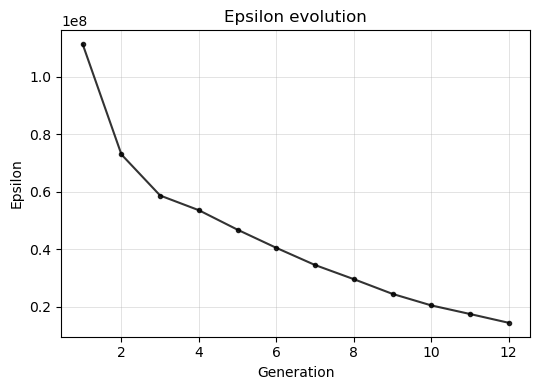

In [53]:
# evolution of epsilon
fig, ax = plt.subplots(figsize=(5.5,4), tight_layout=True)
epsilons = history.get_all_populations()['epsilon'][1:] # note first entry is from calibration and must be discarded
ax.plot(epsilons, c='k', marker='.', alpha=0.8)
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel('Generation')
ax.set_ylabel('Epsilon')
ax.set_title('Epsilon evolution')

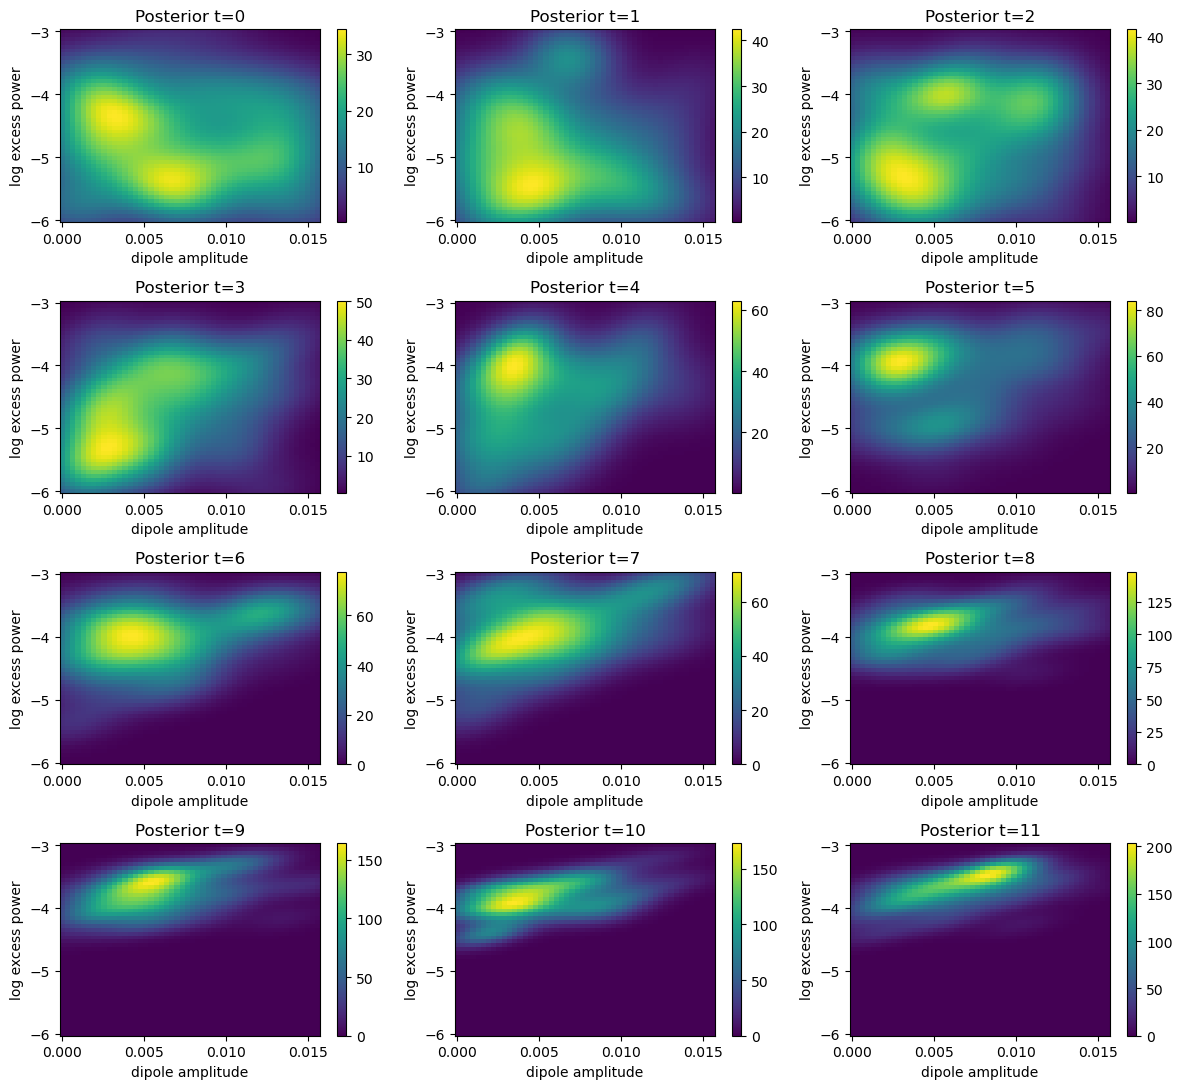

In [57]:
# visualize
fig = plt.figure(figsize=(12, 11), tight_layout=True)
for t in range(history.max_t + 1):
    ax = fig.add_subplot(int(np.ceil(history.max_t / 3)), 3, t + 1)
    df, w = history.get_distribution(t=t)
    ax = pyabc.visualization.plot_kde_2d(
        df,
        w,
        x="dipole_amp",
        xname=r"dipole amplitude",
        xmin=abc.parameter_priors[0]['dipole_amp'].args[0],
        xmax=abc.parameter_priors[0]['dipole_amp'].args[0] + abc.parameter_priors[0]['dipole_amp'].args[1],
        y="log_excess",
        yname=r"log excess power",
        ymin=abc.parameter_priors[0]['log_excess'].args[0],
        ymax=abc.parameter_priors[0]['log_excess'].args[0] + abc.parameter_priors[0]['log_excess'].args[1],
        ax=ax
    )
    ax.set_title(f"Posterior t={t}")

In [58]:
# how do these temporary files work?
saved_history = pyabc.storage.History("sqlite:///" + db_path)
saved_history

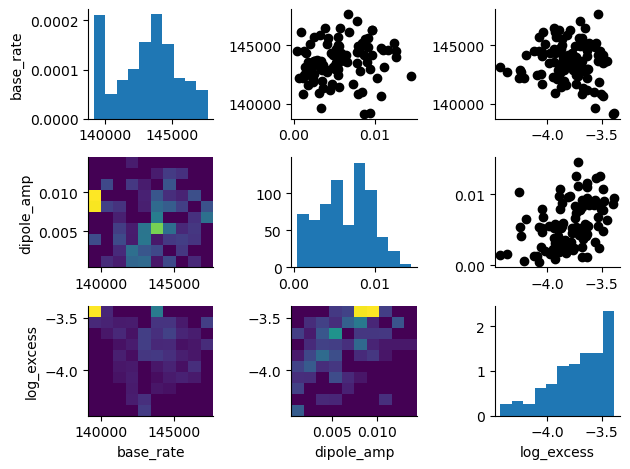

In [59]:
axs = pyabc.visualization.plot_histogram_matrix(history)

## CatWISE

In [90]:
# catwise-specific inputs
fn_cat = f'/scratch/aew492/lss-dipoles_results/data/catalogs/catwise_agns/catwise_agns_master.fits'
selfunc_fn = f'/scratch/aew492/lss-dipoles_results/data/catalogs/catwise_agns/selfuncs/selection_function_NSIDE64_catwise_pluszodis.fits'
expected_dipole_amp = 0.0074

In [91]:
nside = 64
blim = 30

dipole_amp_bounds = (0., 3 * expected_dipole_amp) # first is lower bound, second entry is WIDTH (not upper bound)
log_excess_bounds = (-6, 3)
base_rate_bounds = (1.9e4, 1e3)  # note much higher base rate since healpixels are much bigger; depends on nside

In [92]:
# data and selection function
# load catalog
qmap_raw = tools.load_catalog_as_map(fn_cat, frame='icrs', nside=64)
# add galactic plane mask
qmap = qmap_raw * tools.get_galactic_plane_mask(blim, nside=64, frame='icrs') * small_masks
# downgrade
qmap_dg = hp.ud_grade(qmap, nside, power=-2) # power = -2 preserves the sum of the map => preserves total number of quasars

# selection function: this isn't applied to the data but used to generate the mock skies
small_masks = fitsio.read(f'/scratch/aew492/lss-dipoles_results/data/catalogs/masks/mask_master_hpx_r1.0.fits')
selfunc = hp.read_map(selfunc_fn) * small_masks * tools.get_galactic_plane_mask(blim, nside=64, frame='icrs')
# downgrade
selfunc_dg = hp.pixelfunc.ud_grade(selfunc, nside)

In [93]:
population_size = 50
minimum_epsilon = 100
max_nr_populations = 7

In [94]:
def catwise_model(parameters):
    """
    Generates a healpix density map with dipole in fixed CMB dipole direction and excess angular power.
    Uses fiducial selection function (Quaia + galactic plane mask + smaller masks from S21).

    Parameters
    ----------
    parameters : dict
        keys:
            "dipole_amp" = dipole amplitude
            "log_excess" = log of the excess power (flat in Cell)
            "base_rate" = quasar density base rate

    Returns
    -------
    Quasar overdensity map with nside.
    
    """
    
    rng = np.random.default_rng(seed=None) # should I put a seed in here??

    # expected dipole map
    amps = np.zeros(4)
    amps[1:] = dipole.cmb_dipole(amplitude=parameters["dipole_amp"], return_amps=True)
    expected_dipole_map = dipole.dipole_map(amps, NSIDE=nside)

    # add Cells
    # Cells: flat, determined by input log_excess
    Cells = np.zeros(8) + 10**parameters["log_excess"]
    # draw alms from a Gaussian
    sph_harm_amp_dict = {}
    for ell in range(1, len(Cells)+1):
        sph_harm_amp_dict[ell] = np.sqrt(Cells[ell-1]) * rng.normal(size=2 * ell + 1)
    # then make map from the alms
    excess_map = np.zeros((hp.nside2npix(nside)))
    for ell in sph_harm_amp_dict.keys():
        alms = sph_harm_amp_dict[ell]
        assert len(alms) == 2 * ell + 1, \
            f"incorrect number of coefficients for ell={ell} ({len(alms)}, expected {2 * ell + 1}"
        excess_map += multipoles.multipole_map(alms, NSIDE=nside)

    # smooth overdensity map
    smooth_overdensity_map = expected_dipole_map + excess_map

    # poisson sample, including the base rate and the selfunc map
    overdensity_map = rng.poisson((1. + smooth_overdensity_map) * parameters["base_rate"] * selfunc_dg)

    return { "data" : overdensity_map }

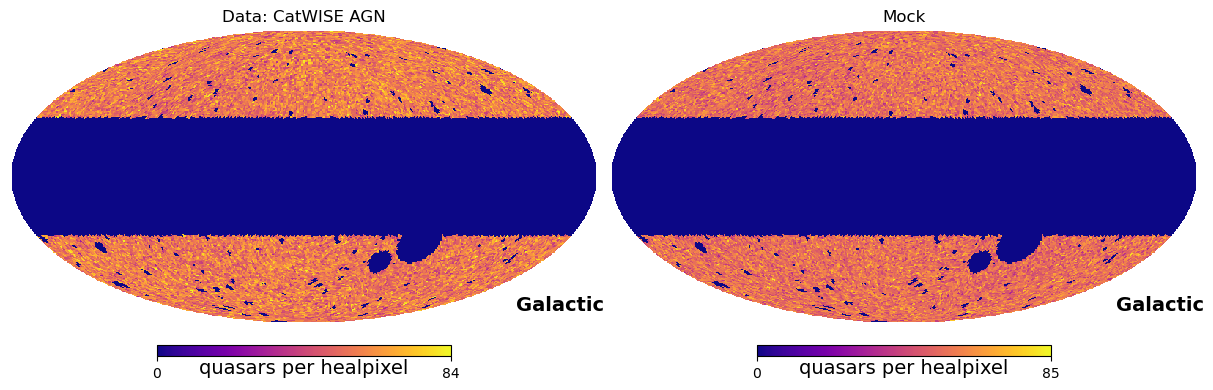

In [97]:
# compare data and mock as a sanity check
mock = catwise_model(dict(dipole_amp=0.0074, log_excess=-6, base_rate=70.))["data"]
fig = plt.figure(figsize=(12,4), tight_layout=True)
hp.mollview(qmap_dg, coord=['C','G'], cmap='plasma', sub=(1,2,1), max=84, title='Data: CatWISE AGN', unit='quasars per healpixel')
hp.mollview(mock, coord=['C','G'], cmap='plasma', sub=(1,2,2), title='Mock', unit='quasars per healpixel')

In [58]:
# prior
prior = pyabc.Distribution(dipole_amp = pyabc.RV("uniform", *dipole_amp_bounds),
                           log_excess = pyabc.RV("uniform", *log_excess_bounds),
                           base_rate = pyabc.RV("uniform", *base_rate_bounds))

In [59]:
# distance
def distance(x, x0):
    return sum((x["data"] - x0["data"])**2)

In [60]:
abc = pyabc.ABCSMC(catwise_model, prior, distance, population_size=population_size)
observation = qmap_dg   # the true data

# store the history at this tempfile
db_path = os.path.join(tempfile.gettempdir(), 'test.db')
abc.new("sqlite:///" + db_path, {"data": observation})

ABC.Sampler INFO: Parallelize sampling on 48 processes.
ABC.History INFO: Start <ABCSMC id=5, start_time=2024-12-25 21:39:28>


In [61]:
# start the sampling!
history = abc.run(minimum_epsilon=minimum_epsilon, max_nr_populations=max_nr_populations)

ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 3.24257700e+08.
ABC INFO: Accepted: 50 / 113 = 4.4248e-01, ESS: 5.0000e+01.
ABC INFO: t: 1, eps: 3.12068594e+08.
ABC INFO: Accepted: 50 / 118 = 4.2373e-01, ESS: 1.7749e+01.
ABC INFO: t: 2, eps: 3.08153481e+08.
ABC INFO: Accepted: 50 / 140 = 3.5714e-01, ESS: 3.9064e+01.
ABC INFO: t: 3, eps: 3.05467292e+08.
ABC INFO: Accepted: 50 / 175 = 2.8571e-01, ESS: 4.0238e+01.
ABC INFO: t: 4, eps: 3.03614549e+08.
ABC INFO: Accepted: 50 / 241 = 2.0747e-01, ESS: 2.4785e+01.
ABC INFO: t: 5, eps: 3.02189542e+08.
ABC INFO: Accepted: 50 / 559 = 8.9445e-02, ESS: 3.7941e+01.
ABC INFO: t: 6, eps: 3.01172332e+08.
ABC INFO: Accepted: 50 / 1012 = 4.9407e-02, ESS: 3.0350e+01.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=5, duration=0:00:49.926410, end_time=2024-12-25 21:40:18>


In [62]:
prior = dict(dipole_amp=dipole_amp_bounds,
             log_excess=log_excess_bounds,
             base_rate=base_rate_bounds)

Text(0.5, 0.98, 'ABC posteriors, CatWISE')

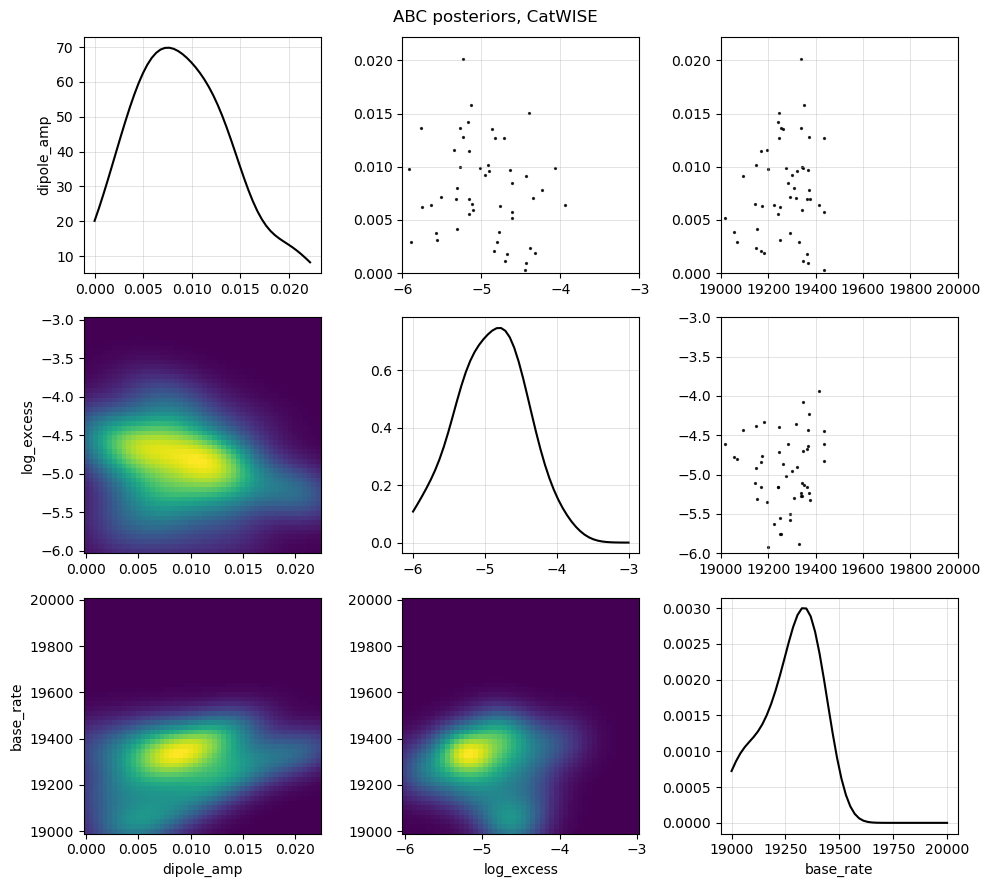

In [63]:
# plot (copied and adjusted from the pyabc.visualization source code)
par_ids = ['dipole_amp', 'log_excess', 'base_rate']
fig, axs = plt.subplots(len(par_ids), len(par_ids), figsize=(10,9), tight_layout=True)
df, w = history.get_distribution()

for i in range(len(par_ids)):

    # diagonal
    ax = axs[i, i]
    x, pdf = get_kde_1d(history, prior, par_ids[i])
    ax.plot(x, pdf, c='k')
    ax.grid(alpha=0.5, lw=0.5)

    axs[i,0].set_ylabel(par_ids[i])
    axs[len(par_ids)-1,i].set_xlabel(par_ids[i])

    for j in range(0, i):

        # lower
        ax = axs[i, j]
        x, y, pdf = get_kde_2d(history, prior, par_ids[j], par_ids[i])
        mesh = ax.pcolormesh(x, y, pdf, shading='auto')

        # upper
        ax = axs[j, i]
        scatter(history, prior, par_ids[i], par_ids[j], ax, color='k', alpha=0.8, marker='.', s=7)
        ax.grid(alpha=0.5, lw=0.5)
        
fig.suptitle(f'ABC posteriors, CatWISE')

## load results

In [6]:
resdir = '/scratch/aew492/lss-dipoles_results/results'

### Quaia

#### nside 1

In [7]:
res = np.load(os.path.join(resdir, 'ABC/quaia_dipole_excess_nside1.npy'), allow_pickle=True).item()
history, prior = res.values()

Text(0.5, 0.98, 'ABC posteriors, nside=1')

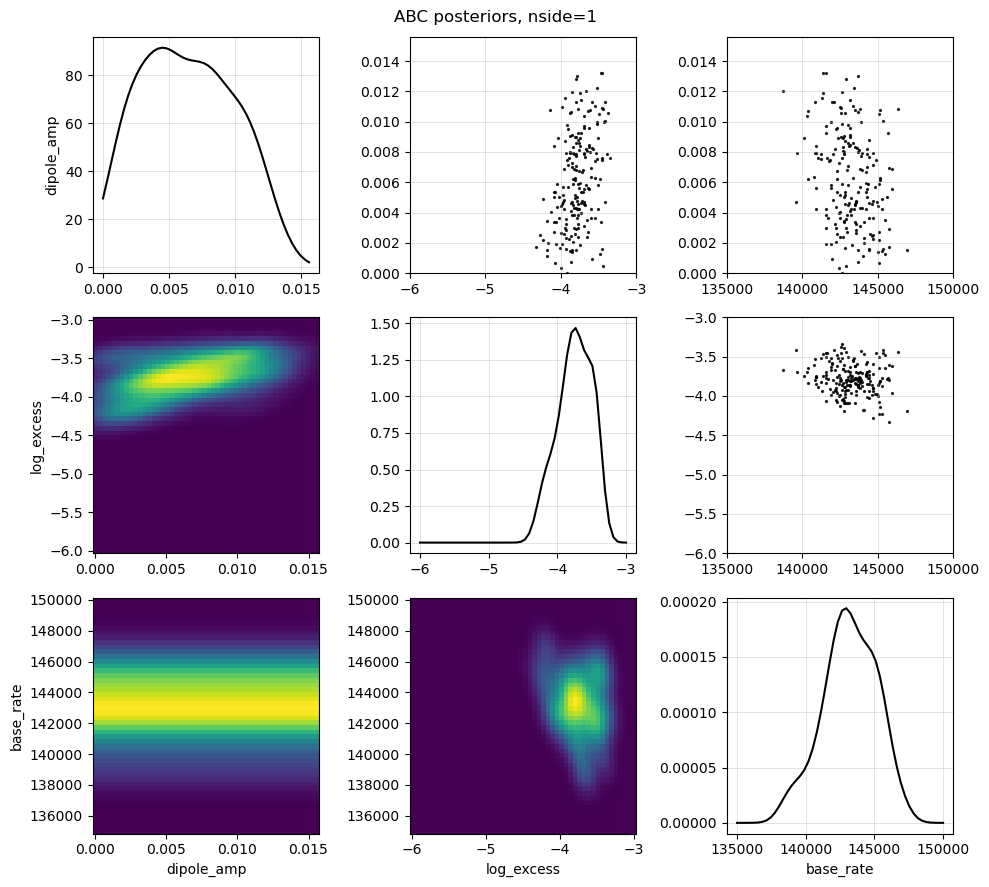

In [8]:
# plot (copied and adjusted from the pyabc.visualization source code)
par_ids = [x for x in prior.keys()]
fig, axs = plt.subplots(len(par_ids), len(par_ids), figsize=(10,9), tight_layout=True)
df, w = history.get_distribution()

for i in range(len(par_ids)):

    # diagonal
    ax = axs[i, i]
    x, pdf = get_kde_1d(history, prior, par_ids[i])
    ax.plot(x, pdf, c='k')
    ax.grid(alpha=0.5, lw=0.5)

    axs[i,0].set_ylabel(par_ids[i])
    axs[len(par_ids)-1,i].set_xlabel(par_ids[i])

    for j in range(0, i):

        # lower
        ax = axs[i, j]
        x, y, pdf = get_kde_2d(history, prior, par_ids[j], par_ids[i])
        mesh = ax.pcolormesh(x, y, pdf, shading='auto')

        # upper
        ax = axs[j, i]
        scatter(history, prior, par_ids[i], par_ids[j], ax, color='k', alpha=0.8, marker='.', s=7)
        ax.grid(alpha=0.5, lw=0.5)
        
fig.suptitle(f'ABC posteriors, nside=1')

#### nside 2

In [9]:
res = np.load(os.path.join(resdir, 'ABC/quaia_dipole_excess_nside2.npy'), allow_pickle=True).item()
history, prior = res.values()

Text(0.5, 0.98, 'ABC posteriors, nside=2')

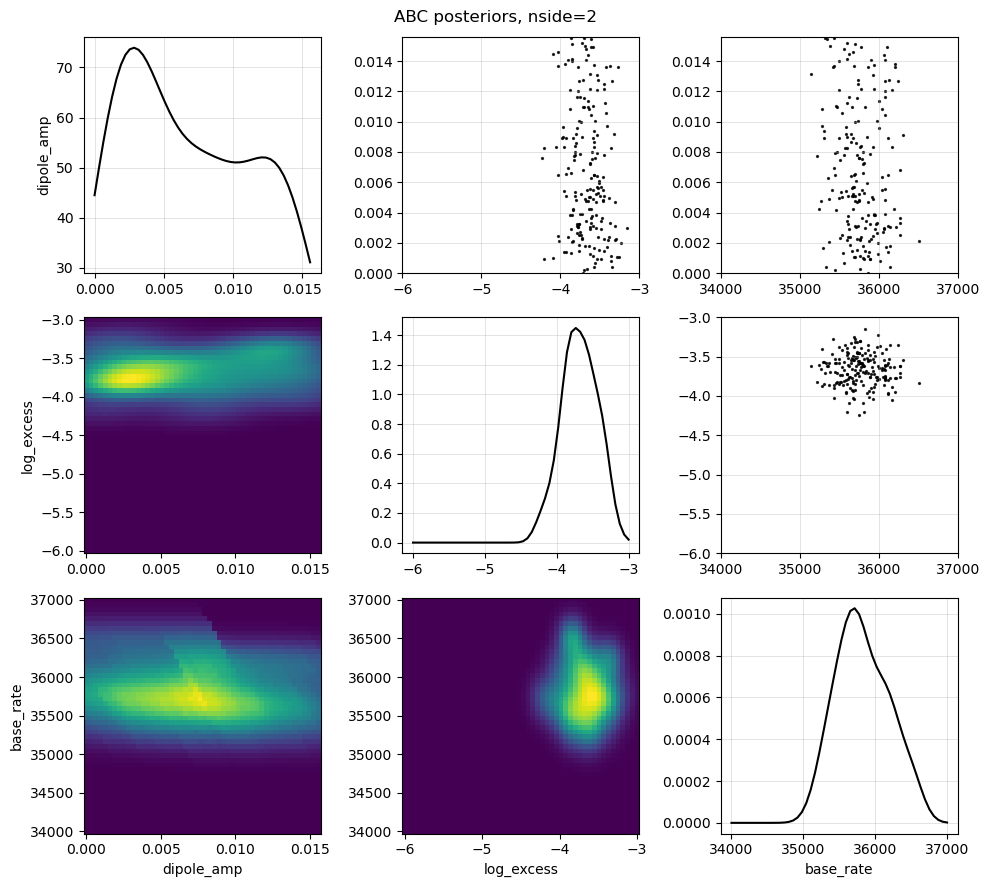

In [10]:
# plot (copied and adjusted from the pyabc.visualization source code)
par_ids = [x for x in prior.keys()]
fig, axs = plt.subplots(len(par_ids), len(par_ids), figsize=(10,9), tight_layout=True)
df, w = history.get_distribution()

for i in range(len(par_ids)):

    # diagonal
    ax = axs[i, i]
    x, pdf = get_kde_1d(history, prior, par_ids[i])
    ax.plot(x, pdf, c='k')
    ax.grid(alpha=0.5, lw=0.5)

    axs[i,0].set_ylabel(par_ids[i])
    axs[len(par_ids)-1,i].set_xlabel(par_ids[i])

    for j in range(0, i):

        # lower
        ax = axs[i, j]
        x, y, pdf = get_kde_2d(history, prior, par_ids[j], par_ids[i])
        mesh = ax.pcolormesh(x, y, pdf, shading='auto')

        # upper
        ax = axs[j, i]
        scatter(history, prior, par_ids[i], par_ids[j], ax, color='k', alpha=0.8, marker='.', s=7)
        ax.grid(alpha=0.5, lw=0.5)
        
fig.suptitle(f'ABC posteriors, nside=2')

#### nside 4

In [11]:
res = np.load(os.path.join(resdir, 'ABC/quaia_dipole_excess_nside4.npy'), allow_pickle=True).item()
history, prior, observation = res.values()

Text(0.5, 0.98, 'ABC posteriors, nside=4')

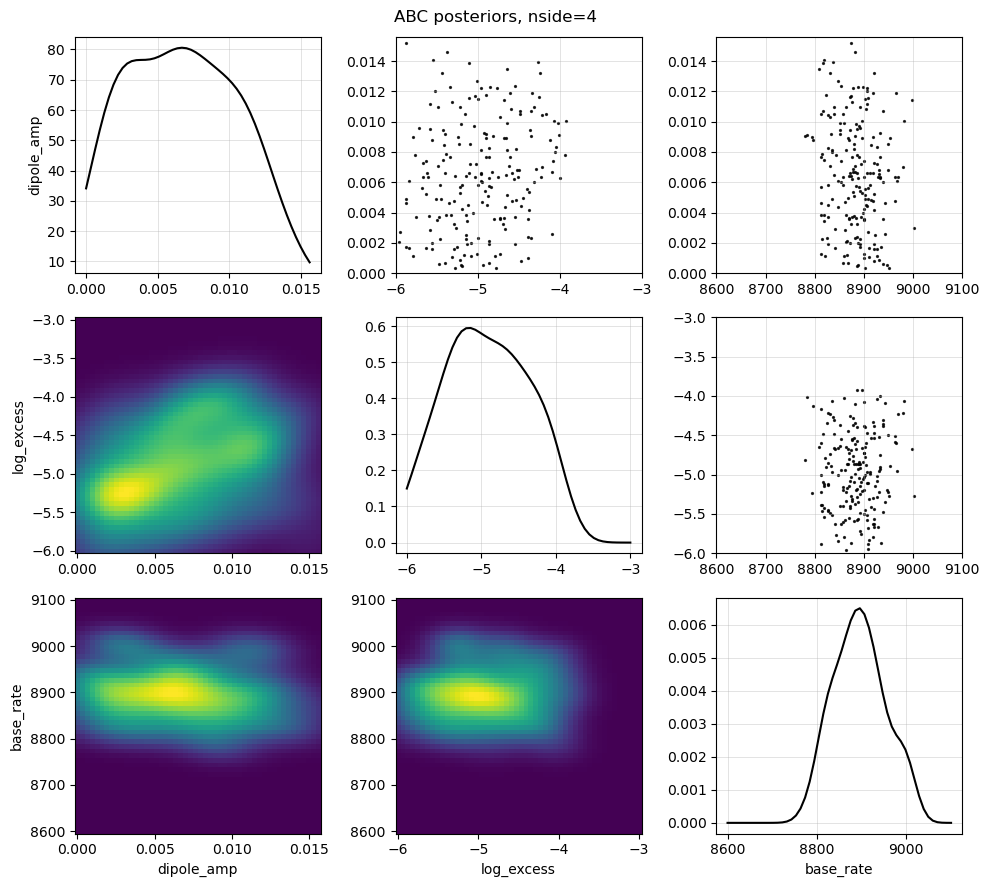

In [12]:
# plot (copied and adjusted from the pyabc.visualization source code)
par_ids = [x for x in prior.keys()]
fig, axs = plt.subplots(len(par_ids), len(par_ids), figsize=(10,9), tight_layout=True)
df, w = history.get_distribution()

for i in range(len(par_ids)):

    # diagonal
    ax = axs[i, i]
    x, pdf = get_kde_1d(history, prior, par_ids[i])
    ax.plot(x, pdf, c='k')
    ax.grid(alpha=0.5, lw=0.5)

    axs[i,0].set_ylabel(par_ids[i])
    axs[len(par_ids)-1,i].set_xlabel(par_ids[i])

    for j in range(0, i):

        # lower
        ax = axs[i, j]
        x, y, pdf = get_kde_2d(history, prior, par_ids[j], par_ids[i])
        mesh = ax.pcolormesh(x, y, pdf, shading='auto')

        # upper
        ax = axs[j, i]
        scatter(history, prior, par_ids[i], par_ids[j], ax, color='k', alpha=0.8, marker='.', s=7)
        ax.grid(alpha=0.5, lw=0.5)
        
fig.suptitle(f'ABC posteriors, nside=4')

#### compare mocks drawn from prior & posterior

In [44]:
nside = 2
# selfunc
selfunc_fn = f'/scratch/aew492/lss-dipoles_results/data/catalogs/quaia/selfuncs/selection_function_NSIDE64_G20.0.fits'
# selection function: this isn't applied to the data but used to generate the mock skies
small_masks = fitsio.read(f'/scratch/aew492/lss-dipoles_results/data/catalogs/masks/mask_master_hpx_r1.0.fits')
selfunc = hp.read_map(selfunc_fn) * small_masks * tools.get_galactic_plane_mask(30, nside=64, frame='icrs')
# downgrade
selfunc_dg = hp.pixelfunc.ud_grade(selfunc, nside)

In [45]:
# load data
fn_cat = f'/scratch/aew492/lss-dipoles_results/data/catalogs/quaia/quaia_G20.0.fits'
qmap_raw = tools.load_catalog_as_map(fn_cat, frame='icrs', nside=64)
# add galactic plane mask
qmap = qmap_raw * tools.get_galactic_plane_mask(30, nside=64, frame='icrs')
qmap_dg = hp.ud_grade(qmap, nside, power=-2)  # power = -2 preserves the sum of the map / total number of quasars

In [46]:
nmocks = 200

In [47]:
# posterior samples
res = np.load(os.path.join(resdir, 'ABC/quaia_dipole_excess_nside2.npy'), allow_pickle=True).item()
history, prior = res.values()
df, w = history.get_distribution()
posterior_pars = []
for i in range(nmocks):
    # draw from the posterior (just in order to ensure no repeats—is there a problem with this?)
    pars = {}
    draw = df.iloc[i]
    for j, key in enumerate(draw.keys()):
        pars[key] = draw.values[j]
    posterior_pars.append(pars)

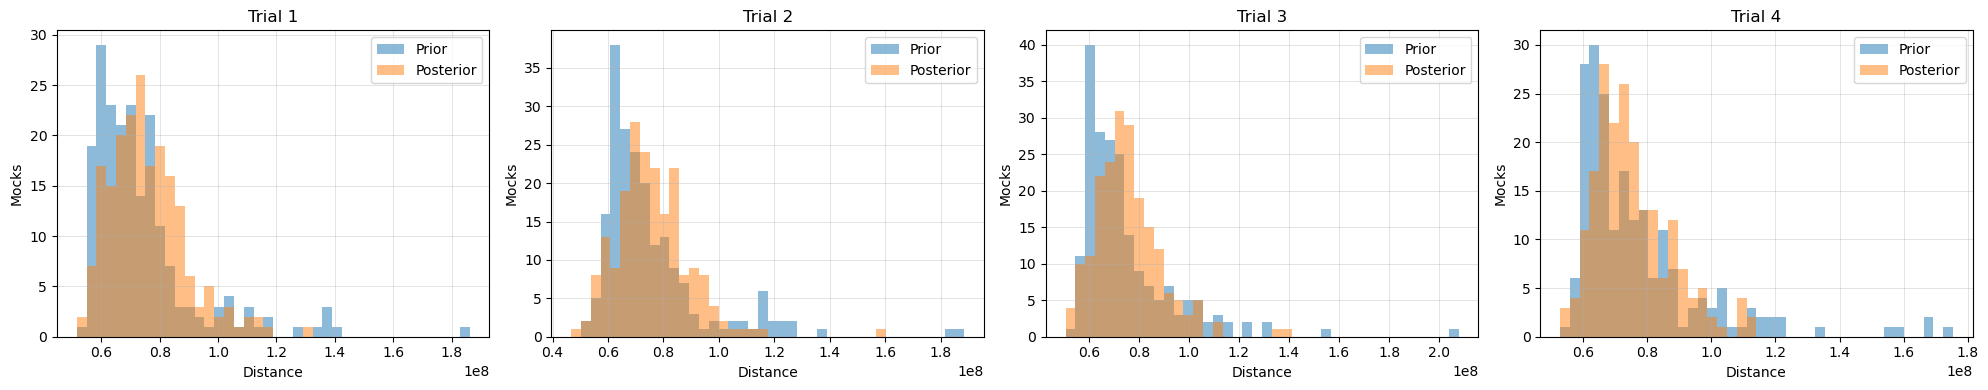

In [48]:
# try a few trials: drawing parameters from the prior, AND constructing the mocks,
#   since there is stochasticity involved in drawing the alms from the 'log_excess' parameter (width of the Gaussian)
ntrials = 4
fig = plt.figure(figsize=(ntrials * 5, 4), tight_layout=True)
for itrial in range(ntrials):
    # draw parameters from the prior
    prior_pars = []
    for i in range(nmocks):
        # randomly draw from the prior
        pars = {}
        for key in prior.keys():
            pars[key] = np.random.uniform(prior[key][0], prior[key][0]+prior[key][1])
        prior_pars.append(pars)
        
    # construct mocks
    prior_mocks = []
    posterior_mocks = []
    for i in range(nmocks):
        prior_mocks.append(model(prior_pars[i], selfunc_dg))
        posterior_mocks.append(model(posterior_pars[i], selfunc_dg))

    # distance between the mock and data
    prior_distances = [
        distance(prior_mock, dict(data=qmap_dg)) for prior_mock in prior_mocks
    ]
    posterior_distances = [
        distance(posterior_mock, dict(data=qmap_dg)) for posterior_mock in posterior_mocks
    ]

    ax = fig.add_subplot(1, ntrials, itrial+1)
    kwargs = dict(alpha=0.5, histtype='stepfilled', bins=np.linspace(np.min([prior_distances, posterior_distances]),
                                                                     np.max([prior_distances, posterior_distances]), 41))
    _, _, _ = ax.hist(prior_distances, label='Prior', **kwargs)
    _, _, _ = ax.hist(posterior_distances, label='Posterior', **kwargs)
    ax.grid(alpha=0.5, lw=0.5)
    ax.set_xlabel('Distance')
    ax.set_ylabel('Mocks')
    ax.legend()
    ax.set_title(f'Trial {itrial+1}')

<Figure size 1200x400 with 0 Axes>

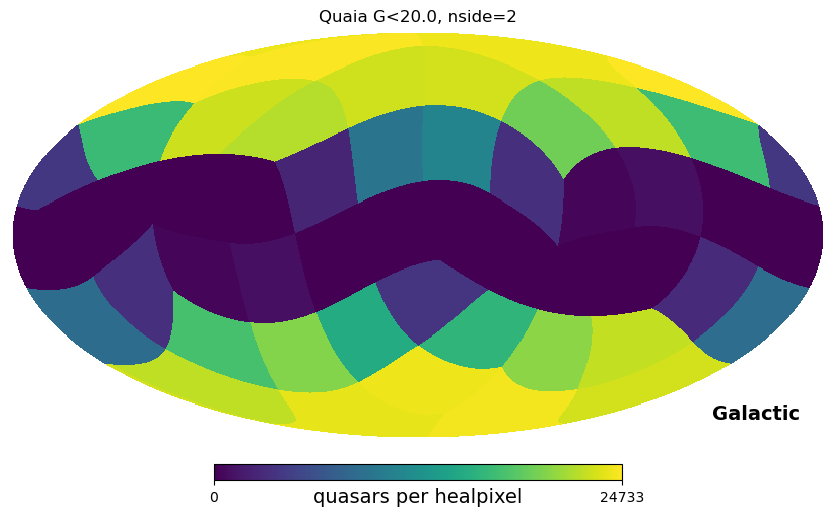

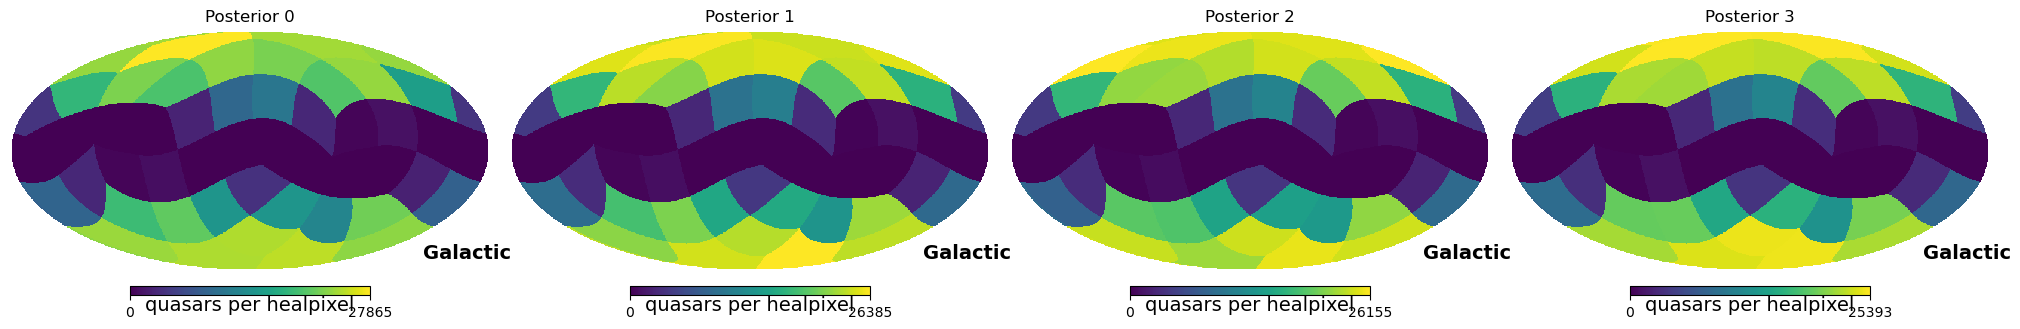

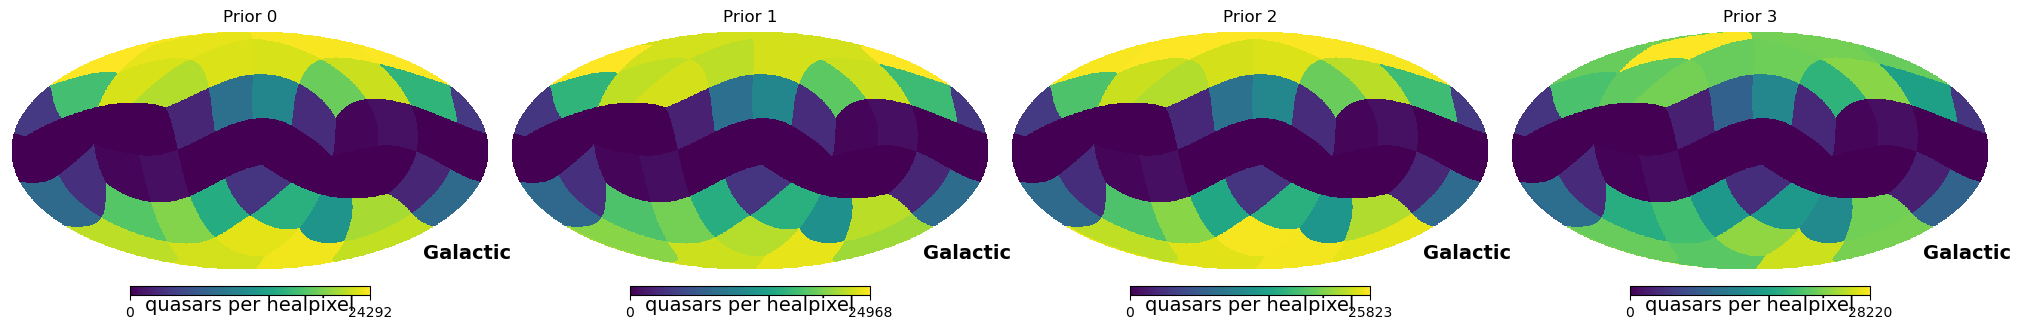

In [49]:
# PLOT #
ntoplot = 4
kwargs = dict(coord=['C','G'], unit='quasars per healpixel', cmap='viridis')
# data
fig = plt.figure(figsize=(12,4))
hp.mollview(qmap_dg, title=f'Quaia G<20.0, nside={nside}', **kwargs)
# from posterior & prior
fig1 = plt.figure(figsize=(20,12/ntoplot))
for i in range(ntoplot):
    hp.mollview(posterior_mocks[i]['data'], title=f'Posterior {i}', sub=(1, ntoplot, i+1), fig=fig1, **kwargs)
fig2 = plt.figure(figsize=(20,12/ntoplot))
for i in range(ntoplot):
    hp.mollview(prior_mocks[i]['data'], title=f'Prior {i}', sub=(1, ntoplot, i+1), fig=fig2, **kwargs)

Okay, as suggested by the prior & posterior $\varepsilon$ distributions in the historgram, there isn't a clear visual difference between the mocks drawn from the prior and those drawn from the posterior.
BUT I'm realizing these maps are highly $a_{\ell m}$ dependent, and I only save the log excess power, so the maps shown above are not the exact maps that were accepted or rejected.
Should I be saving the specific $a_{\ell m}$ coefficients? like have each one be a parameter ?? that seems extreme

In [50]:
# same thing for nside=4

nside = 4
# selfunc
selfunc_fn = f'/scratch/aew492/lss-dipoles_results/data/catalogs/quaia/selfuncs/selection_function_NSIDE64_G20.0.fits'
# selection function: this isn't applied to the data but used to generate the mock skies
small_masks = fitsio.read(f'/scratch/aew492/lss-dipoles_results/data/catalogs/masks/mask_master_hpx_r1.0.fits')
selfunc = hp.read_map(selfunc_fn) * small_masks * tools.get_galactic_plane_mask(30, nside=64, frame='icrs')
# downgrade
selfunc_dg = hp.pixelfunc.ud_grade(selfunc, nside)

# load data
fn_cat = f'/scratch/aew492/lss-dipoles_results/data/catalogs/quaia/quaia_G20.0.fits'
qmap_raw = tools.load_catalog_as_map(fn_cat, frame='icrs', nside=64)
# add galactic plane mask
qmap = qmap_raw * tools.get_galactic_plane_mask(30, nside=64, frame='icrs')
qmap_dg = hp.ud_grade(qmap, nside, power=-2)  # power = -2 preserves the sum of the map / total number of quasars

In [51]:
nmocks = 200

In [52]:
# posterior samples
res = np.load(os.path.join(resdir, 'ABC/quaia_dipole_excess_nside4.npy'), allow_pickle=True).item()
history, prior, observation = res.values()
df, w = history.get_distribution()
posterior_pars = []
for i in range(nmocks):
    # draw from the posterior (just in order to ensure no repeats—is there a problem with this?)
    pars = {}
    draw = df.iloc[i]
    for j, key in enumerate(draw.keys()):
        pars[key] = draw.values[j]
    posterior_pars.append(pars)

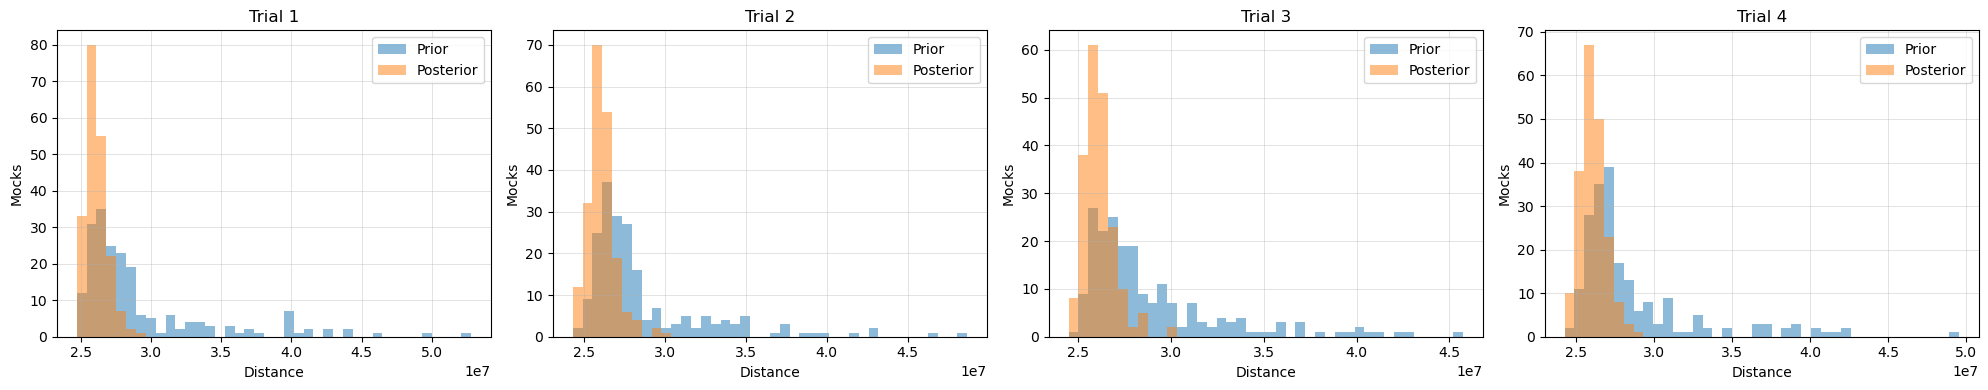

In [53]:
# try a few trials: drawing parameters from the prior, AND constructing the mocks,
#   since there is stochasticity involved in drawing the alms from the 'log_excess' parameter (width of the Gaussian)
ntrials = 4
fig = plt.figure(figsize=(ntrials * 5, 4), tight_layout=True)
for itrial in range(ntrials):
    # draw parameters from the prior
    prior_pars = []
    for i in range(nmocks):
        # randomly draw from the prior
        pars = {}
        for key in prior.keys():
            pars[key] = np.random.uniform(prior[key][0], prior[key][0]+prior[key][1])
        prior_pars.append(pars)
        
    # construct mocks
    prior_mocks = []
    posterior_mocks = []
    for i in range(nmocks):
        prior_mocks.append(model(prior_pars[i], selfunc_dg))
        posterior_mocks.append(model(posterior_pars[i], selfunc_dg))

    # distance between the mock and data
    prior_distances = [
        distance(prior_mock, dict(data=qmap_dg)) for prior_mock in prior_mocks
    ]
    posterior_distances = [
        distance(posterior_mock, dict(data=qmap_dg)) for posterior_mock in posterior_mocks
    ]

    ax = fig.add_subplot(1, ntrials, itrial+1)
    kwargs = dict(alpha=0.5, histtype='stepfilled', bins=np.linspace(np.min([prior_distances, posterior_distances]),
                                                                     np.max([prior_distances, posterior_distances]), 41))
    _, _, _ = ax.hist(prior_distances, label='Prior', **kwargs)
    _, _, _ = ax.hist(posterior_distances, label='Posterior', **kwargs)
    ax.grid(alpha=0.5, lw=0.5)
    ax.set_xlabel('Distance')
    ax.set_ylabel('Mocks')
    ax.legend()
    ax.set_title(f'Trial {itrial+1}')

<Figure size 1200x400 with 0 Axes>

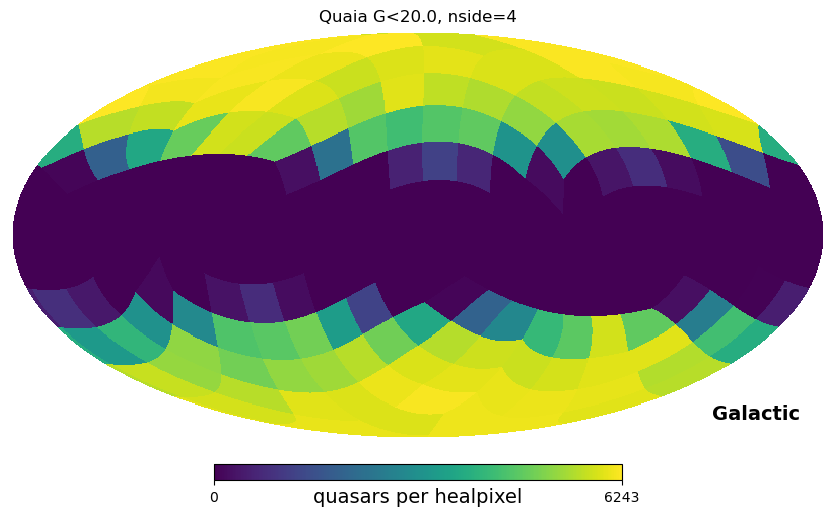

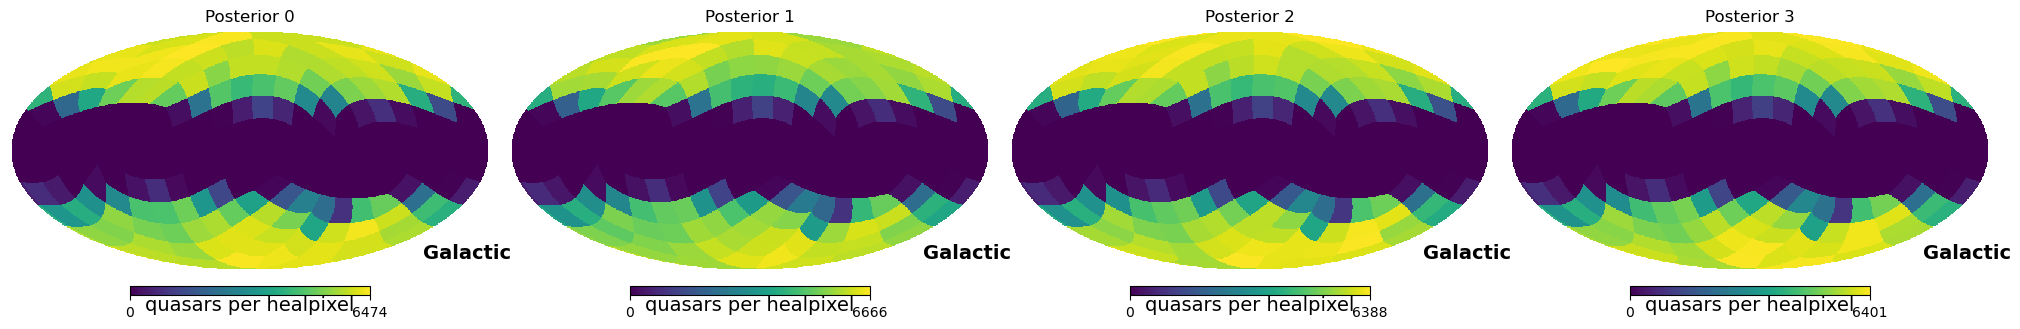

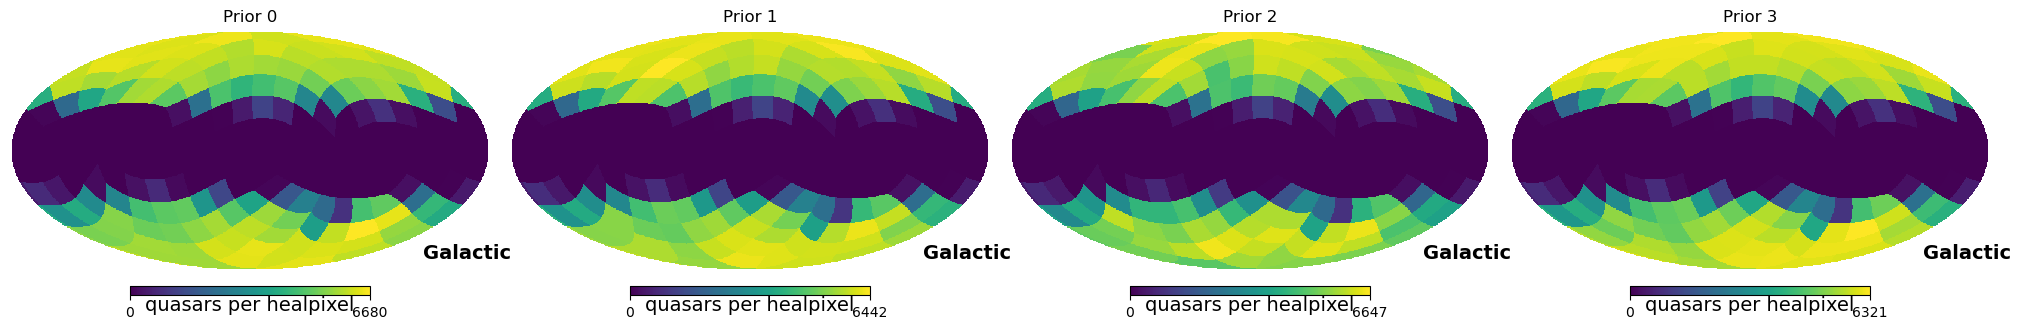

In [54]:
# PLOT #
ntoplot = 4
kwargs = dict(coord=['C','G'], unit='quasars per healpixel', cmap='viridis')
# data
fig = plt.figure(figsize=(12,4))
hp.mollview(qmap_dg, title=f'Quaia G<20.0, nside={nside}', **kwargs)
# from posterior & prior
fig1 = plt.figure(figsize=(20,12/ntoplot))
for i in range(ntoplot):
    hp.mollview(posterior_mocks[i]['data'], title=f'Posterior {i}', sub=(1, ntoplot, i+1), fig=fig1, **kwargs)
fig2 = plt.figure(figsize=(20,12/ntoplot))
for i in range(ntoplot):
    hp.mollview(prior_mocks[i]['data'], title=f'Prior {i}', sub=(1, ntoplot, i+1), fig=fig2, **kwargs)

### CatWISE results

#### nside 1

In [30]:
res = np.load(os.path.join(resdir, 'ABC/catwise_dipole_excess_nside1.npy'), allow_pickle=True).item()
history, prior = res.values()

Text(0.5, 0.98, 'ABC posteriors, nside=1')

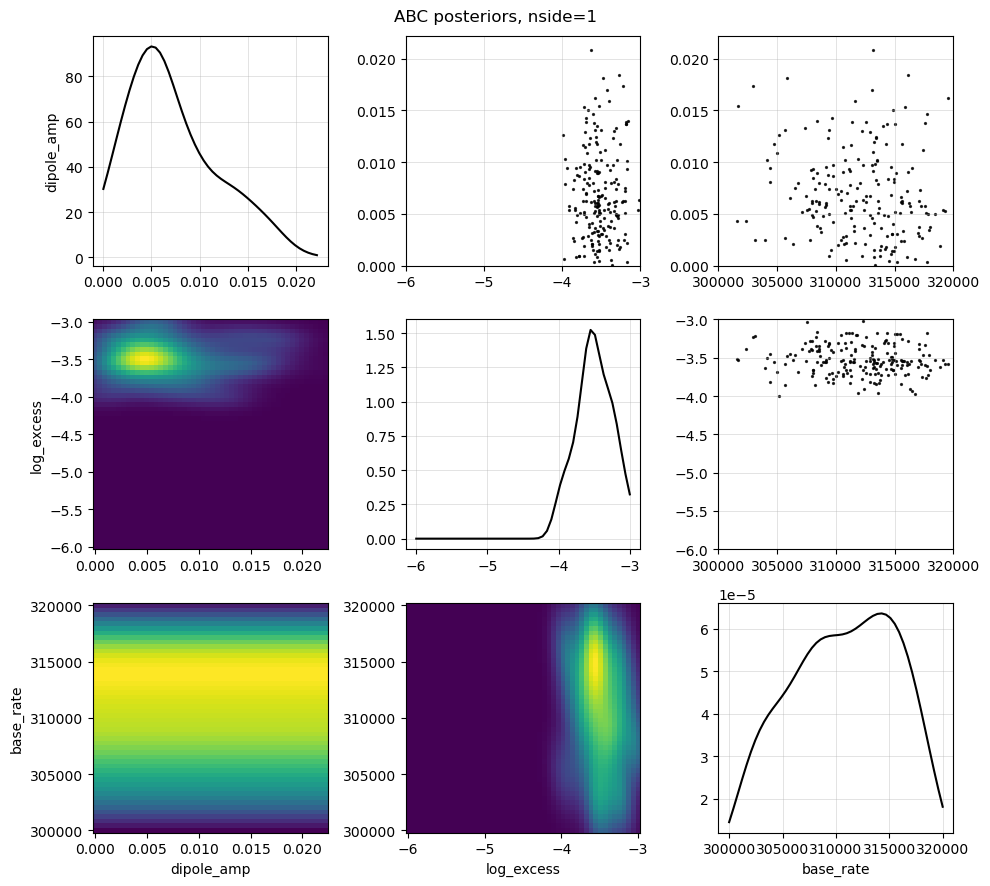

In [31]:
# plot (copied and adjusted from the pyabc.visualization source code)
par_ids = [x for x in prior.keys()]
fig, axs = plt.subplots(len(par_ids), len(par_ids), figsize=(10,9), tight_layout=True)
df, w = history.get_distribution()

for i in range(len(par_ids)):

    # diagonal
    ax = axs[i, i]
    x, pdf = get_kde_1d(history, prior, par_ids[i])
    ax.plot(x, pdf, c='k')
    ax.grid(alpha=0.5, lw=0.5)

    axs[i,0].set_ylabel(par_ids[i])
    axs[len(par_ids)-1,i].set_xlabel(par_ids[i])

    for j in range(0, i):

        # lower
        ax = axs[i, j]
        x, y, pdf = get_kde_2d(history, prior, par_ids[j], par_ids[i])
        mesh = ax.pcolormesh(x, y, pdf, shading='auto')

        # upper
        ax = axs[j, i]
        scatter(history, prior, par_ids[i], par_ids[j], ax, color='k', alpha=0.8, marker='.', s=7)
        ax.grid(alpha=0.5, lw=0.5)
        
fig.suptitle(f'ABC posteriors, nside=1')

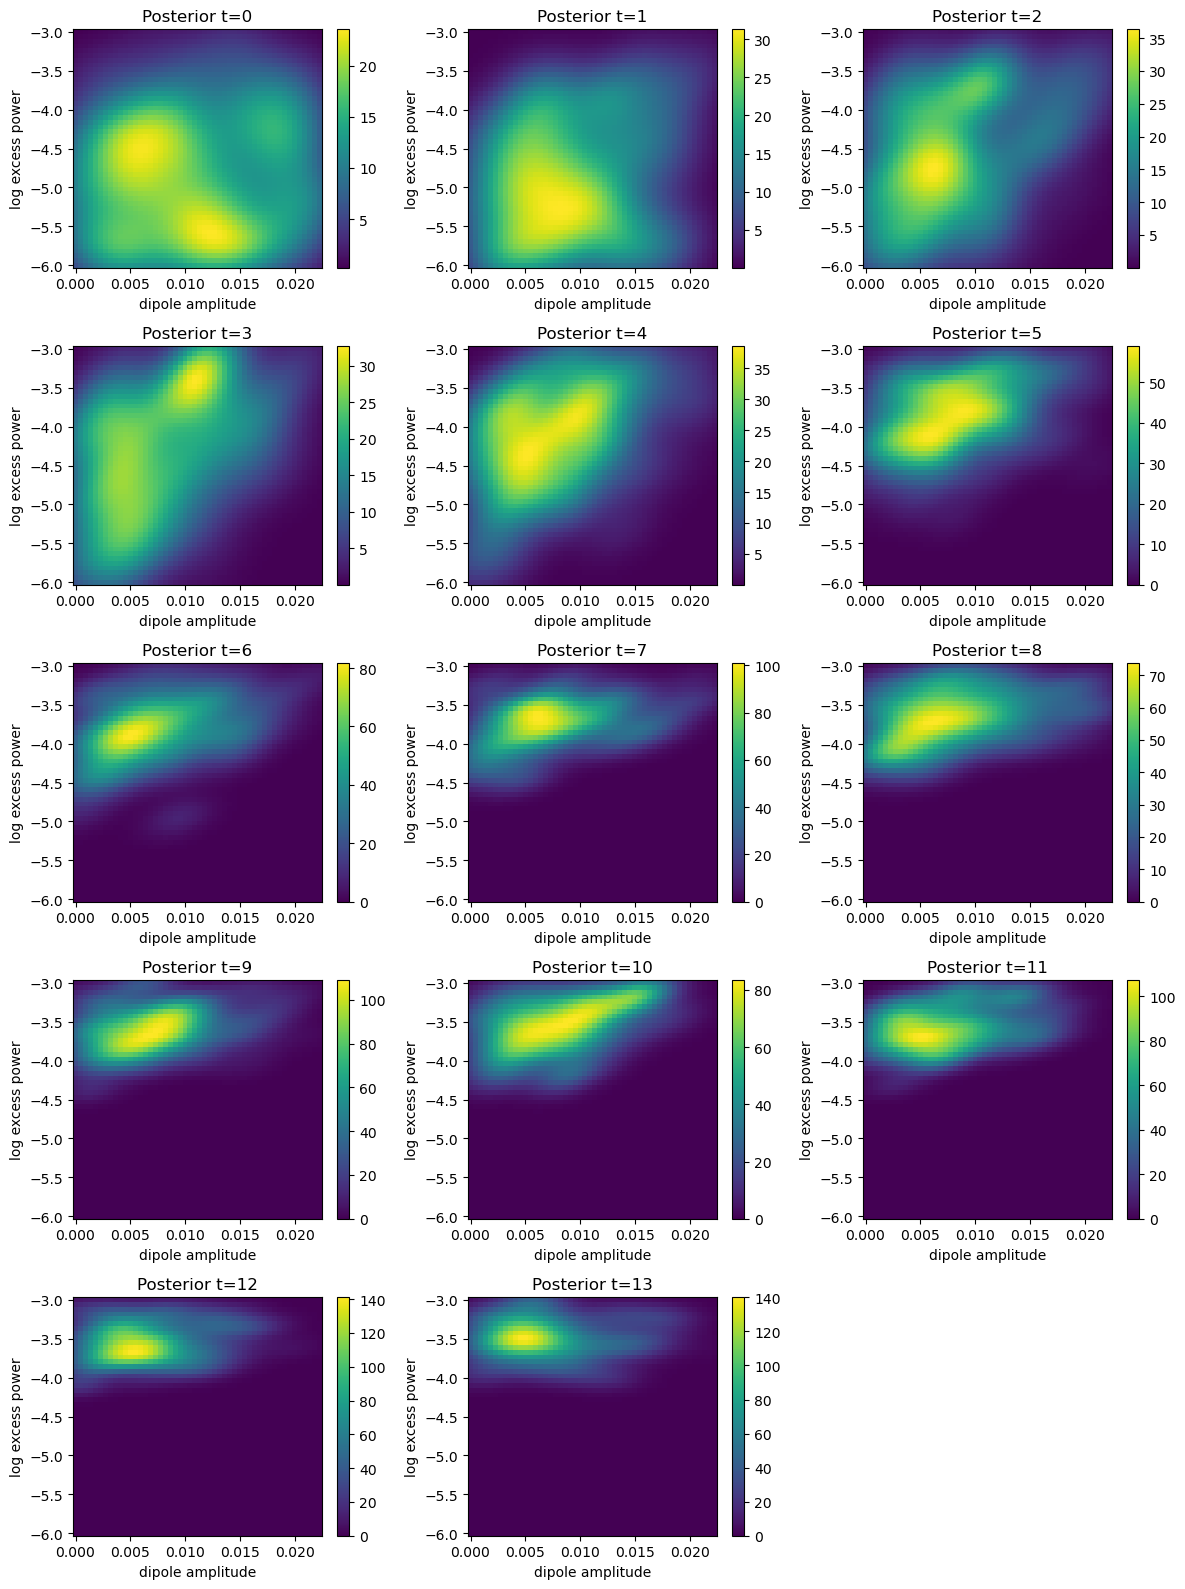

In [32]:
# evolution of the posterior
fig = plt.figure(figsize=(12, 16), tight_layout=True)
for t in range(history.max_t + 1):
    ax = fig.add_subplot(int(np.ceil(history.max_t / 3)), 3, t + 1)
    df, w = history.get_distribution(t=t)
    ax = pyabc.visualization.plot_kde_2d(
        df,
        w,
        x="dipole_amp",
        xname=r"dipole amplitude",
        xmin=prior['dipole_amp'][0],
        xmax=prior['dipole_amp'][0] + prior['dipole_amp'][1],
        y="log_excess",
        yname=r"log excess power",
        ymin=prior['log_excess'][0],
        ymax=prior['log_excess'][0] + prior['log_excess'][1],
        ax=ax
    )
    ax.set_title(f"Posterior t={t}")

#### nside 2

In [33]:
res = np.load(os.path.join(resdir, 'ABC/catwise_dipole_excess_nside2.npy'), allow_pickle=True).item()
history, prior = res.values()

Text(0.5, 0.98, 'ABC posteriors, nside=2')

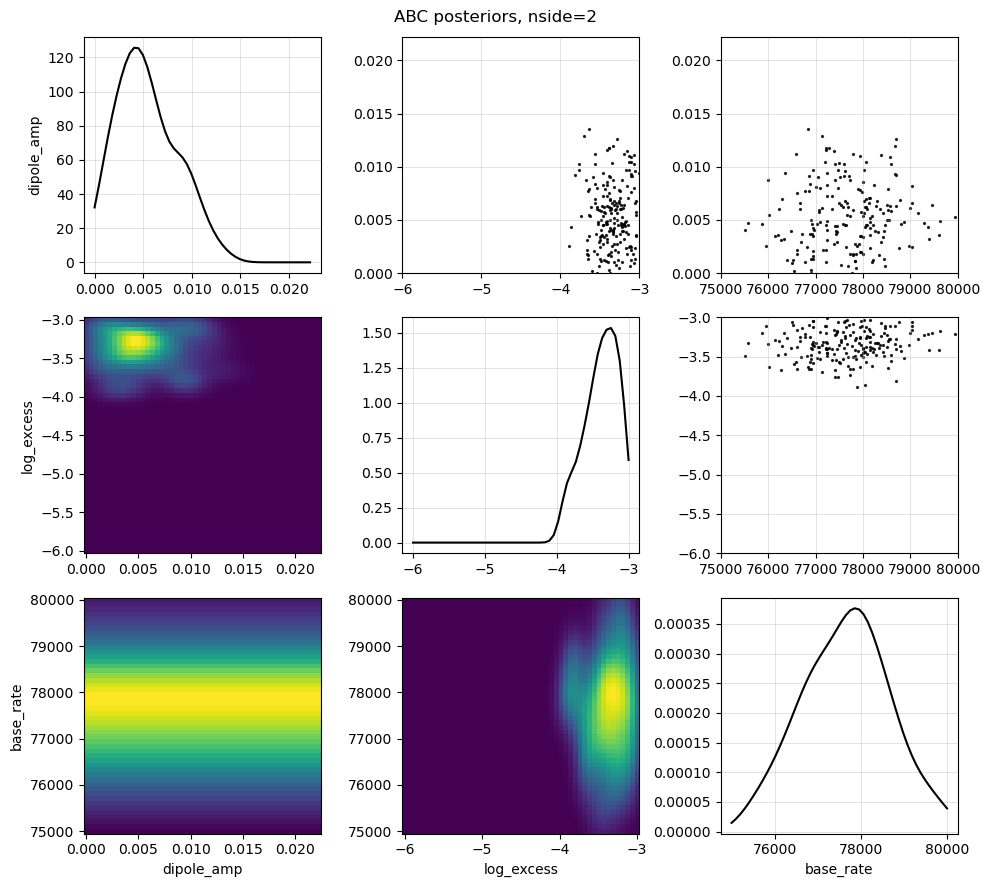

In [34]:
# plot (copied and adjusted from the pyabc.visualization source code)
par_ids = [x for x in prior.keys()]
fig, axs = plt.subplots(len(par_ids), len(par_ids), figsize=(10,9), tight_layout=True)
df, w = history.get_distribution()

for i in range(len(par_ids)):

    # diagonal
    ax = axs[i, i]
    x, pdf = get_kde_1d(history, prior, par_ids[i])
    ax.plot(x, pdf, c='k')
    ax.grid(alpha=0.5, lw=0.5)

    axs[i,0].set_ylabel(par_ids[i])
    axs[len(par_ids)-1,i].set_xlabel(par_ids[i])

    for j in range(0, i):

        # lower
        ax = axs[i, j]
        x, y, pdf = get_kde_2d(history, prior, par_ids[j], par_ids[i])
        mesh = ax.pcolormesh(x, y, pdf, shading='auto')

        # upper
        ax = axs[j, i]
        scatter(history, prior, par_ids[i], par_ids[j], ax, color='k', alpha=0.8, marker='.', s=7)
        ax.grid(alpha=0.5, lw=0.5)
        
fig.suptitle(f'ABC posteriors, nside=2')

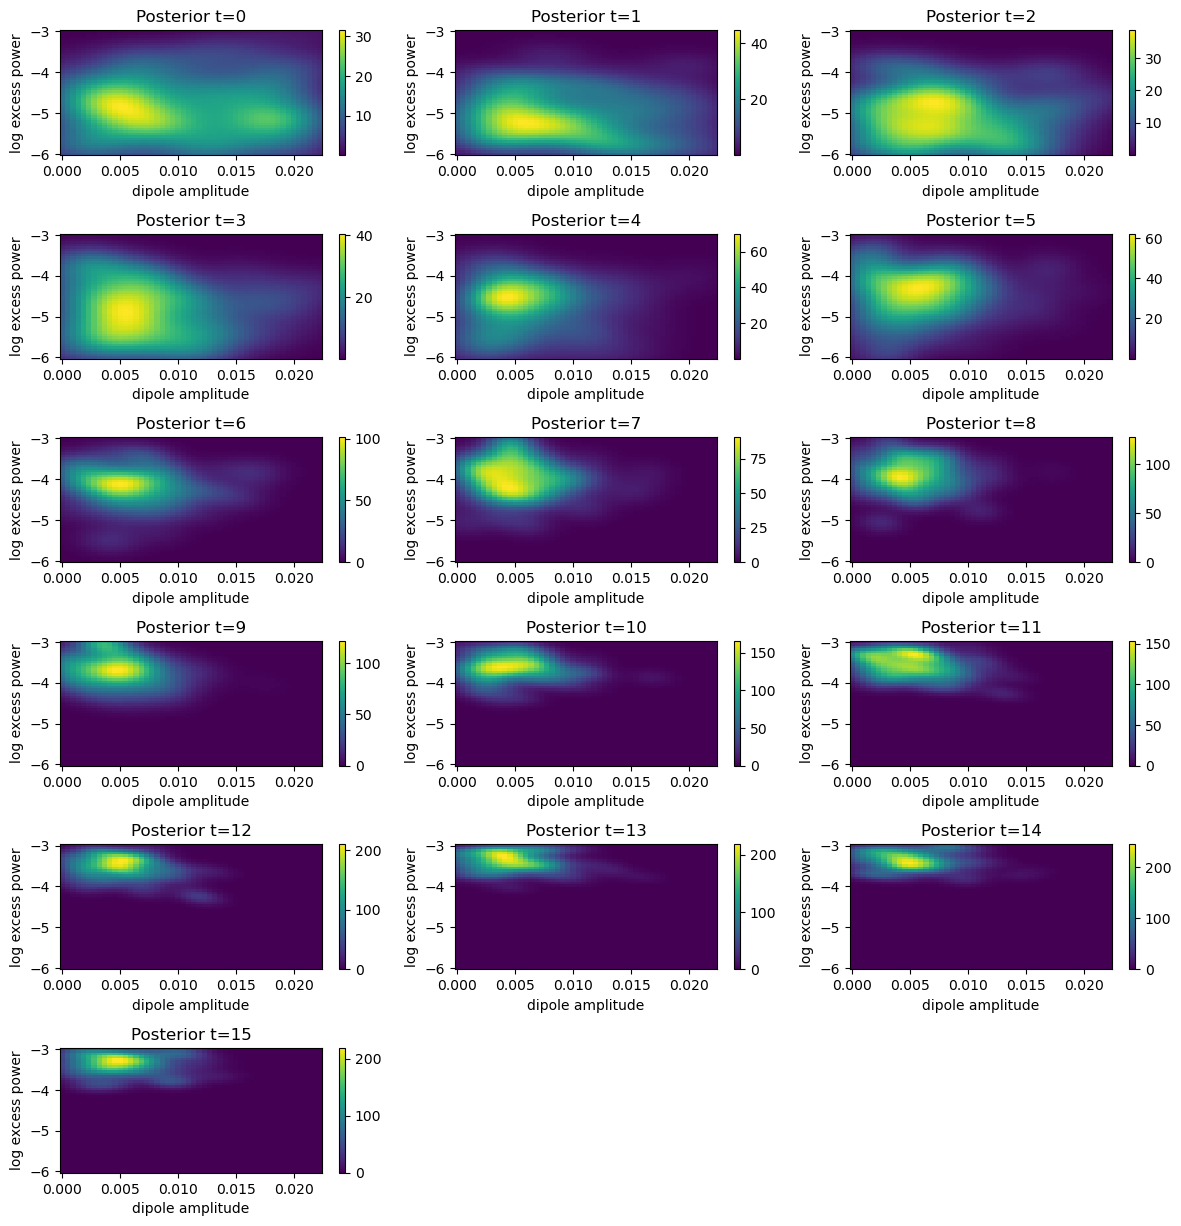

In [35]:
# evolution of the posterior
fig = plt.figure(figsize=(12, 16), tight_layout=True)
for t in range(history.max_t + 1):
    ax = fig.add_subplot(int(np.ceil(history.max_t / 2)), 3, t + 1)
    df, w = history.get_distribution(t=t)
    ax = pyabc.visualization.plot_kde_2d(
        df,
        w,
        x="dipole_amp",
        xname=r"dipole amplitude",
        xmin=prior['dipole_amp'][0],
        xmax=prior['dipole_amp'][0] + prior['dipole_amp'][1],
        y="log_excess",
        yname=r"log excess power",
        ymin=prior['log_excess'][0],
        ymax=prior['log_excess'][0] + prior['log_excess'][1],
        ax=ax
    )
    ax.set_title(f"Posterior t={t}")

#### nside 4

In [36]:
res = np.load(os.path.join(resdir, 'ABC/catwise_dipole_excess_nside4.npy'), allow_pickle=True).item()
history, prior, observation = res.values()

Text(0.5, 0.98, 'ABC posteriors, nside=4')

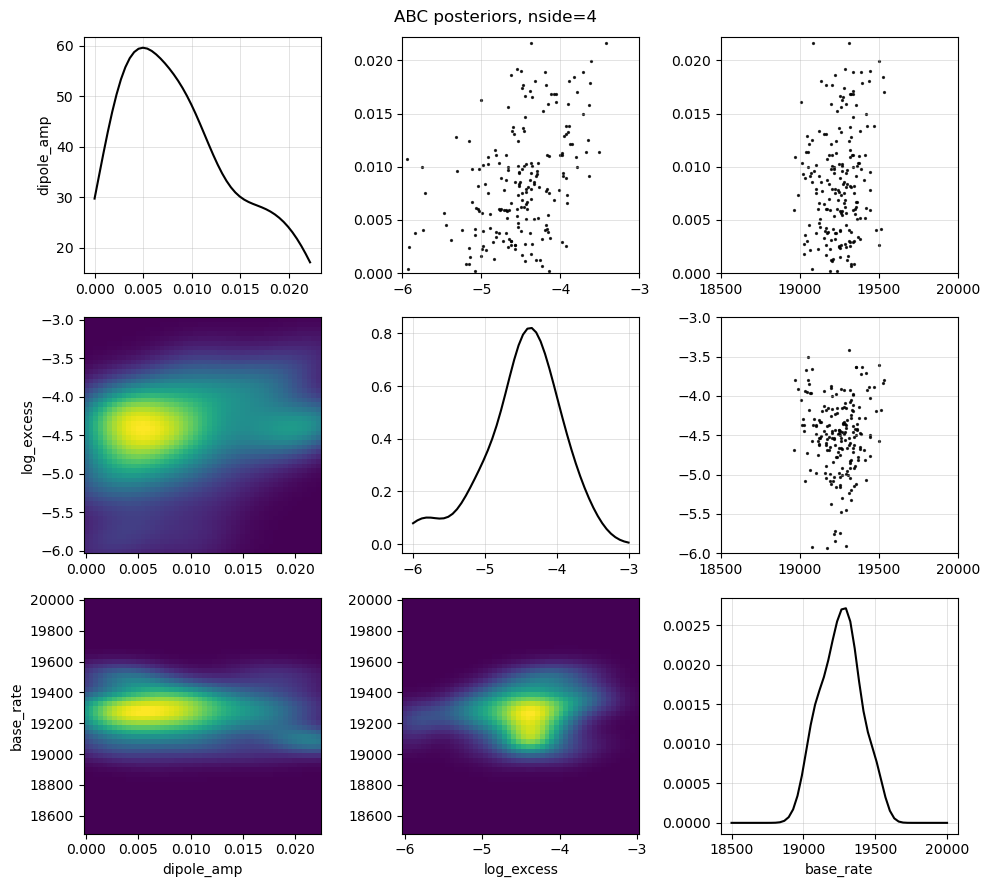

In [37]:
# plot (copied and adjusted from the pyabc.visualization source code)
par_ids = [x for x in prior.keys()]
fig, axs = plt.subplots(len(par_ids), len(par_ids), figsize=(10,9), tight_layout=True)
df, w = history.get_distribution()

for i in range(len(par_ids)):

    # diagonal
    ax = axs[i, i]
    x, pdf = get_kde_1d(history, prior, par_ids[i])
    ax.plot(x, pdf, c='k')
    ax.grid(alpha=0.5, lw=0.5)

    axs[i,0].set_ylabel(par_ids[i])
    axs[len(par_ids)-1,i].set_xlabel(par_ids[i])

    for j in range(0, i):

        # lower
        ax = axs[i, j]
        x, y, pdf = get_kde_2d(history, prior, par_ids[j], par_ids[i])
        mesh = ax.pcolormesh(x, y, pdf, shading='auto')

        # upper
        ax = axs[j, i]
        scatter(history, prior, par_ids[i], par_ids[j], ax, color='k', alpha=0.8, marker='.', s=7)
        ax.grid(alpha=0.5, lw=0.5)
        
fig.suptitle(f'ABC posteriors, nside=4')

In [100]:
res = np.load(os.path.join(resdir, 'ABC/catwise_dipole_excess_nside4_masks.npy'), allow_pickle=True).item()
history, prior, observation = res.values()

Text(0.5, 0.98, 'ABC posteriors, nside=4')

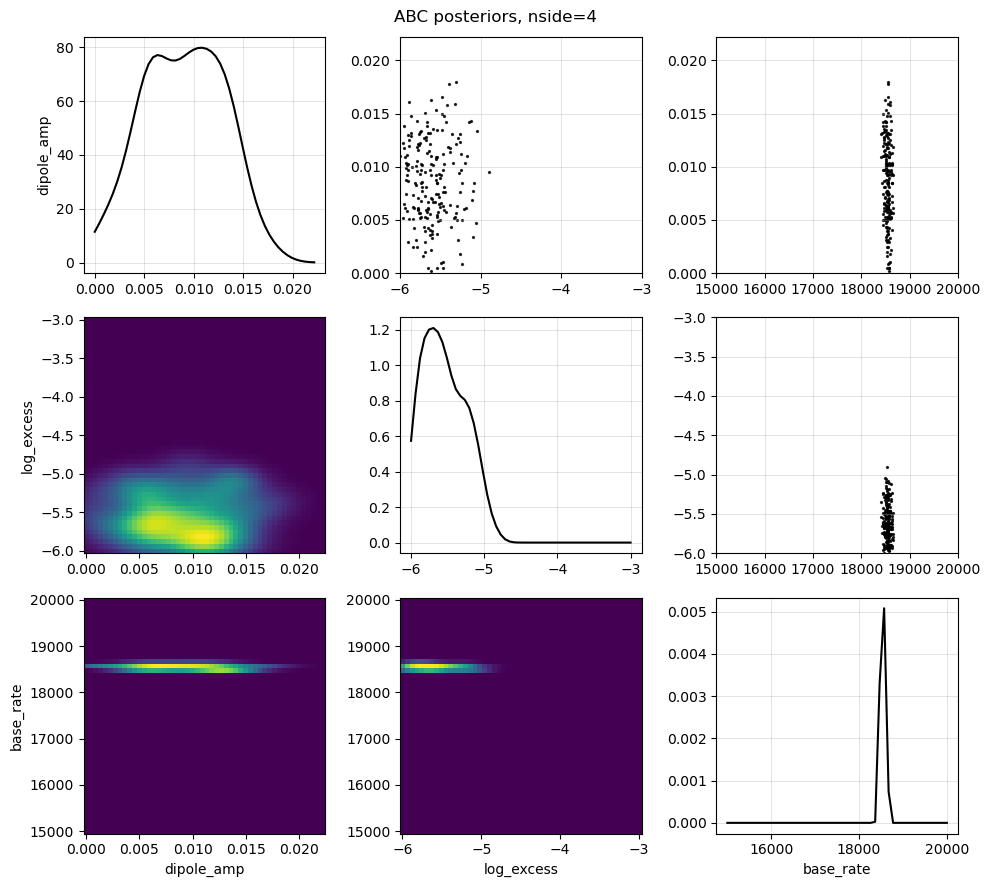

In [101]:
# plot (copied and adjusted from the pyabc.visualization source code)
par_ids = [x for x in prior.keys()]
fig, axs = plt.subplots(len(par_ids), len(par_ids), figsize=(10,9), tight_layout=True)
df, w = history.get_distribution()

for i in range(len(par_ids)):

    # diagonal
    ax = axs[i, i]
    x, pdf = get_kde_1d(history, prior, par_ids[i])
    ax.plot(x, pdf, c='k')
    ax.grid(alpha=0.5, lw=0.5)

    axs[i,0].set_ylabel(par_ids[i])
    axs[len(par_ids)-1,i].set_xlabel(par_ids[i])

    for j in range(0, i):

        # lower
        ax = axs[i, j]
        x, y, pdf = get_kde_2d(history, prior, par_ids[j], par_ids[i])
        mesh = ax.pcolormesh(x, y, pdf, shading='auto')

        # upper
        ax = axs[j, i]
        scatter(history, prior, par_ids[i], par_ids[j], ax, color='k', alpha=0.8, marker='.', s=7)
        ax.grid(alpha=0.5, lw=0.5)
        
fig.suptitle(f'ABC posteriors, nside=4')

#### get some samples from the prior and posterior

In [109]:
nside = 4
# selfunc
selfunc_fn = f'/scratch/aew492/lss-dipoles_results/data/catalogs/catwise_agns/selfuncs/selection_function_NSIDE64_catwise_pluszodis.fits'
# selection function: this isn't applied to the data but used to generate the mock skies
small_masks = fitsio.read(f'/scratch/aew492/lss-dipoles_results/data/catalogs/masks/mask_master_hpx_r1.0.fits')
selfunc = hp.read_map(selfunc_fn) * small_masks * tools.get_galactic_plane_mask(30, nside=64, frame='icrs')
# downgrade
selfunc_dg = hp.pixelfunc.ud_grade(selfunc, nside)

# load data
fn_cat = f'/scratch/aew492/lss-dipoles_results/data/catalogs/catwise_agns/catwise_agns_master.fits'
qmap_raw = tools.load_catalog_as_map(fn_cat, frame='icrs', nside=64)
# add galactic plane mask
qmap = qmap_raw * tools.get_galactic_plane_mask(30, nside=64, frame='icrs') * small_masks
qmap_dg = hp.ud_grade(qmap, nside, power=-2)  # power = -2 preserves the sum of the map / total number of quasarsa4

In [110]:
nmocks = 200

In [111]:
# posterior samples
res = np.load(os.path.join(resdir, 'ABC/catwise_dipole_excess_nside4_masks.npy'), allow_pickle=True).item()
history, prior, observation = res.values()
df, w = history.get_distribution()
posterior_pars = []
for i in range(nmocks):
    # draw from the posterior (just in order to ensure no repeats—is there a problem with this?)
    pars = {}
    draw = df.iloc[i]
    for j, key in enumerate(draw.keys()):
        pars[key] = draw.values[j]
    posterior_pars.append(pars)

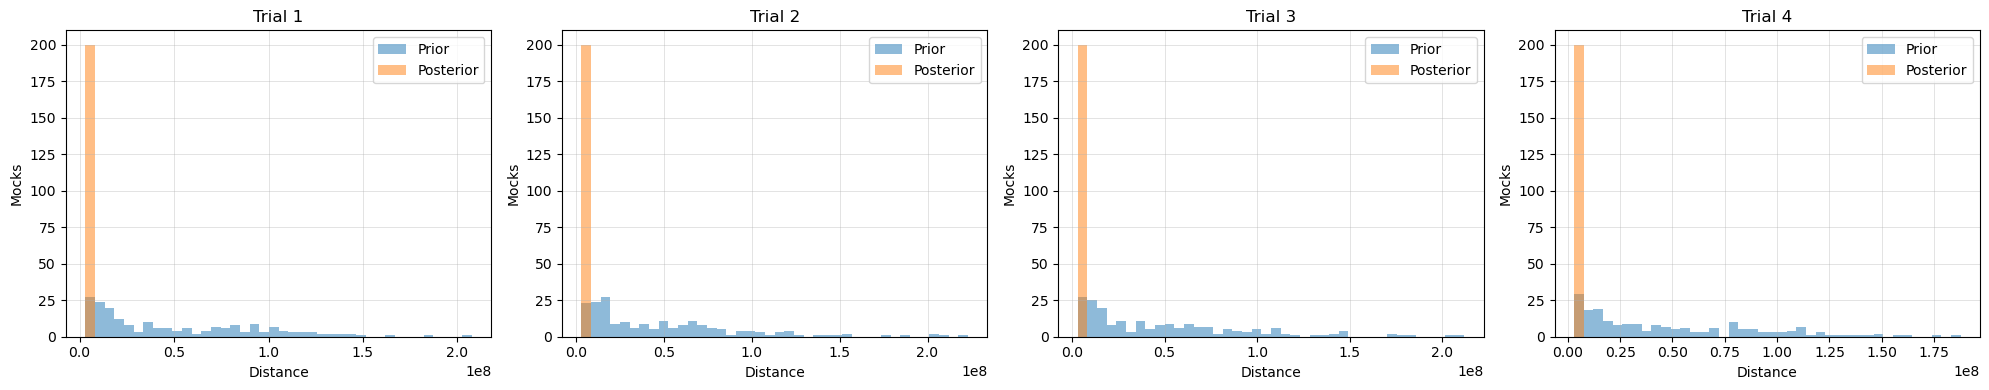

In [112]:
# try a few trials: drawing parameters from the prior, AND constructing the mocks,
#   since there is stochasticity involved in drawing the alms from the 'log_excess' parameter (width of the Gaussian)
ntrials = 4
fig = plt.figure(figsize=(ntrials * 5, 4), tight_layout=True)
for itrial in range(ntrials):
    # draw parameters from the prior
    prior_pars = []
    for i in range(nmocks):
        # randomly draw from the prior
        pars = {}
        for key in prior.keys():
            pars[key] = np.random.uniform(prior[key][0], prior[key][0]+prior[key][1])
        prior_pars.append(pars)
        
    # construct mocks
    prior_mocks = []
    posterior_mocks = []
    for i in range(nmocks):
        prior_mocks.append(model(prior_pars[i], selfunc_dg))
        posterior_mocks.append(model(posterior_pars[i], selfunc_dg))

    # distance between the mock and data
    prior_distances = [
        distance(prior_mock, dict(data=qmap_dg)) for prior_mock in prior_mocks
    ]
    posterior_distances = [
        distance(posterior_mock, dict(data=qmap_dg)) for posterior_mock in posterior_mocks
    ]

    ax = fig.add_subplot(1, ntrials, itrial+1)
    kwargs = dict(alpha=0.5, histtype='stepfilled', bins=np.linspace(np.min([prior_distances, posterior_distances]),
                                                                     np.max([prior_distances, posterior_distances]), 41))
    _, _, _ = ax.hist(prior_distances, label='Prior', **kwargs)
    _, _, _ = ax.hist(posterior_distances, label='Posterior', **kwargs)
    ax.grid(alpha=0.5, lw=0.5)
    ax.set_xlabel('Distance')
    ax.set_ylabel('Mocks')
    ax.legend()
    ax.set_title(f'Trial {itrial+1}')

<Figure size 1200x400 with 0 Axes>

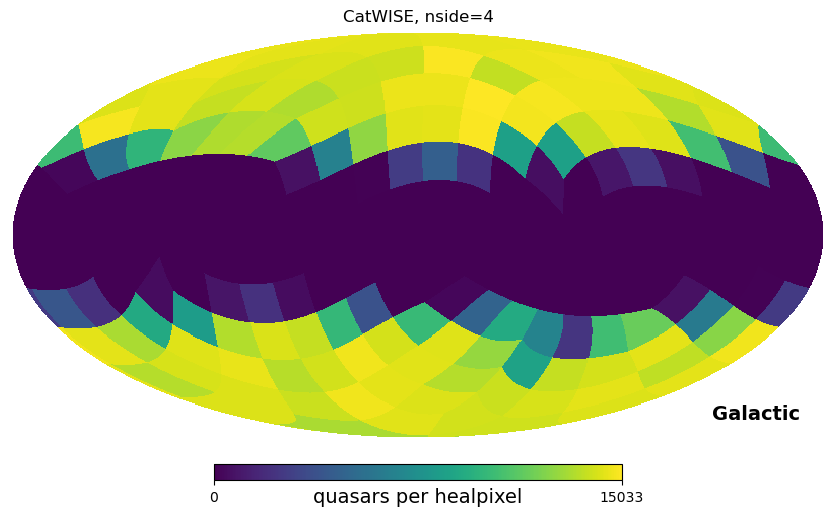

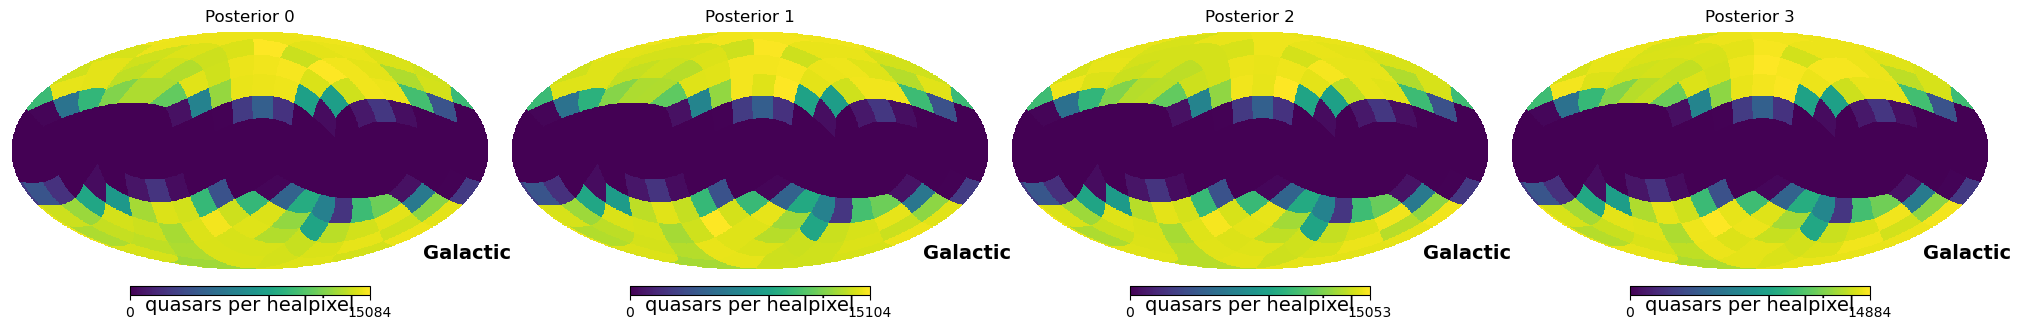

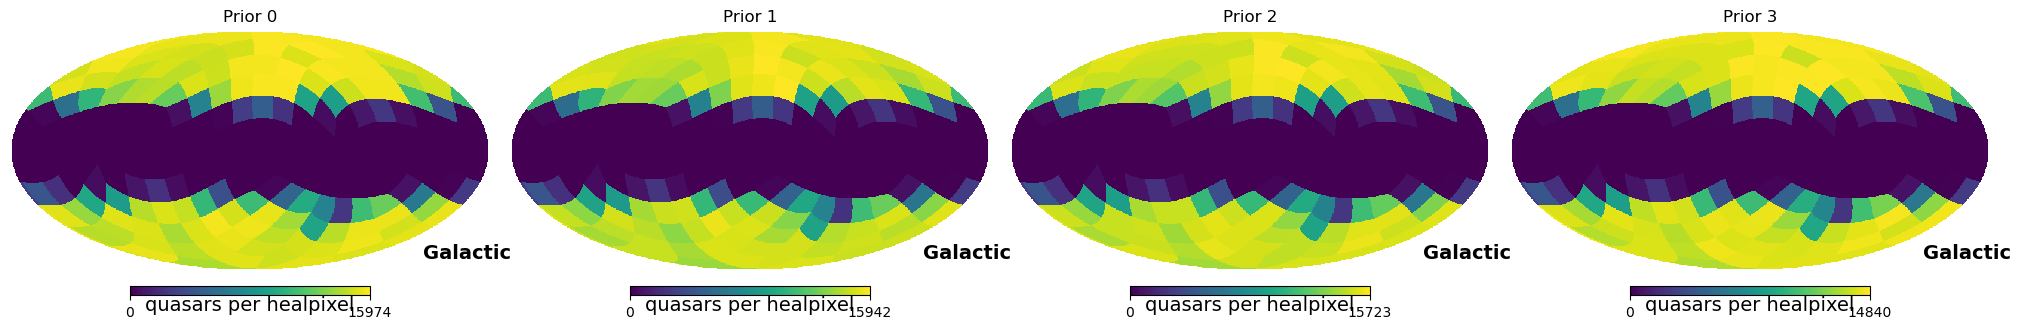

In [113]:
# PLOT #
ntoplot = 4
kwargs = dict(coord=['C','G'], unit='quasars per healpixel', cmap='viridis')
# data
fig = plt.figure(figsize=(12,4))
hp.mollview(qmap_dg, title=f'CatWISE, nside={nside}', **kwargs)
# from posterior & prior
fig1 = plt.figure(figsize=(20,12/ntoplot))
for i in range(ntoplot):
    hp.mollview(posterior_mocks[i]['data'], title=f'Posterior {i}', sub=(1, ntoplot, i+1), fig=fig1, **kwargs)
fig2 = plt.figure(figsize=(20,12/ntoplot))
for i in range(ntoplot):
    hp.mollview(prior_mocks[i]['data'], title=f'Prior {i}', sub=(1, ntoplot, i+1), fig=fig2, **kwargs)

### try to get some Cells

In [128]:
nside = 2

In [129]:
# for Quaia
# load results
res = np.load(os.path.join(resdir, 'ABC/quaia_dipole_excess_nside2.npy'), allow_pickle=True).item()
history, prior = res.values()

# get parameters of the final accepted mocks
df, w = history.get_distribution()

In [130]:
# regularization
Lambda = 0.

In [131]:
# data Cells
res_data = np.load(os.path.join(resdir, f'results_data/Cells_Lambda-{Lambda:.1e}_quaia_G20.0_case-quaia_G20.0_orig.npy'),
              allow_pickle=True).item()

In [136]:
ntocalc = 20
Cells = np.empty((ntocalc, len(res_data['ells'])))
# generate the mocks
for i in range(ntocalc):
    print(f"{i:02d} of {ntocalc}", end='\r')
    mock = model(df.iloc[i], selfunc_dg)['data']
    odmap = dipole.overdensity_map(mock['data'], selfunc)
    ells, Cells[i] = multipoles.compute_Cells_in_overdensity_map_Lambda(odmap,
                                                                Lambda=Lambda,
                                                                max_ell=8, # magic
                                                                selfunc=selfunc)

pars:  name
base_rate     35695.146232
dipole_amp        0.003104
log_excess       -3.308758
Name: 11805, dtype: float64


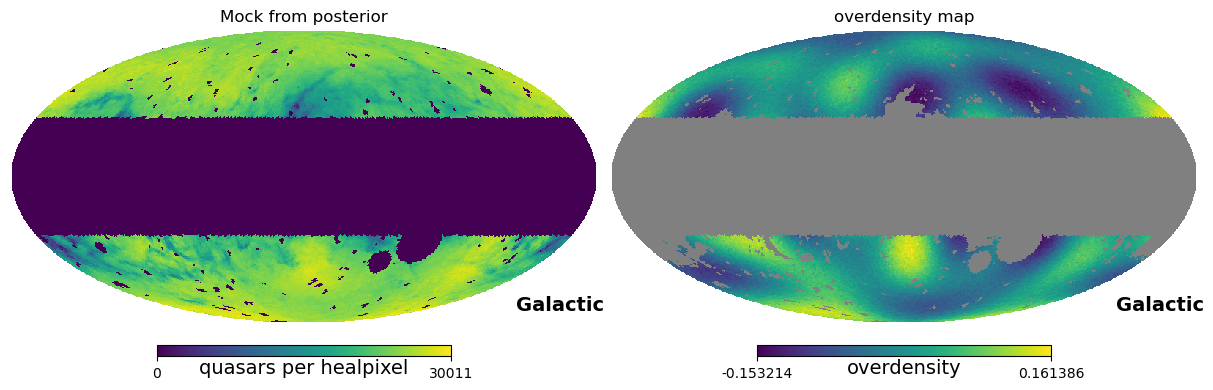

In [157]:
print("pars: ", df.iloc[0])
mock = model(df.iloc[0], selfunc)['data']
odmap = dipole.overdensity_map(mock, selfunc)
fig = plt.figure(figsize=(12,4))
hp.mollview(mock, coord=['C','G'], unit='quasars per healpixel', title='Mock from posterior', sub=(1,2,1))
hp.mollview(odmap, coord=['C','G'], unit='overdensity', title='overdensity map', sub=(1,2,2))

Wrong base rate with nside 64!!!

/home/aew492/lss-dipoles/code/dipole.py:90: RuntimeWarning: divide by zero encountered in divide
  qmap_corrected = qmap / selfunc # Hogg is dying here


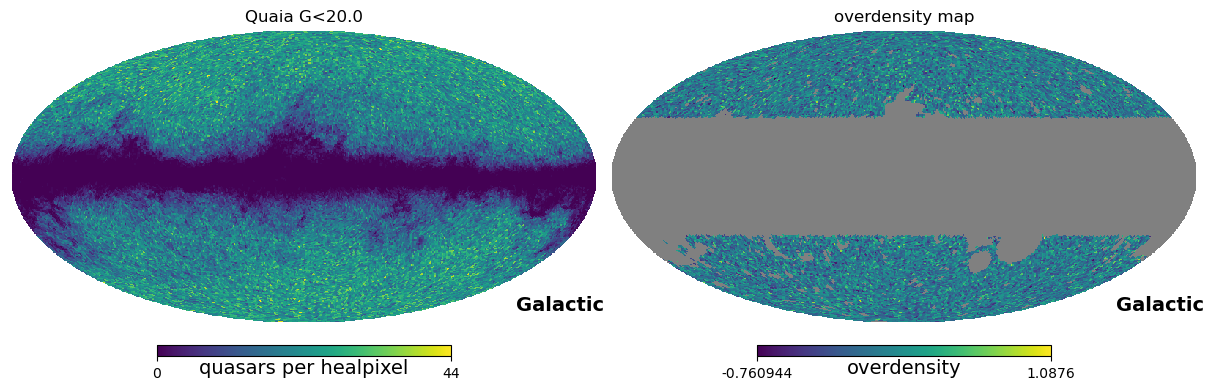

In [149]:
# compare to the data
fn_cat = '/scratch/aew492/lss-dipoles_results/data/catalogs/quaia/quaia_G20.0.fits'
qmap = tools.load_catalog_as_map(fn_cat, frame='icrs', nside=64)
odmap = dipole.overdensity_map(qmap, selfunc)
fig = plt.figure(figsize=(12,4))
hp.mollview(qmap, coord=['C','G'], unit='quasars per healpixel', title='Quaia G<20.0', sub=(1,2,1))
hp.mollview(odmap, coord=['C','G'], unit='overdensity', title='overdensity map', sub=(1,2,2))

In [137]:
# average
mean_Cells_posterior = np.mean(Cells, axis=0)

In [139]:
log_excess = df.iloc[:ntocalc]['log_excess'].values
log_excess

array([-3.30875817, -3.83464305, -3.60377261, -3.48260234, -3.73932081,
       -3.6080333 , -3.94381347, -3.61772326, -3.3604948 , -3.22814231,
       -3.45406333, -3.31401911, -3.82287366, -3.27028325, -3.44349884,
       -3.76274488, -3.75487091, -3.53547367, -3.93274826, -3.8602438 ])

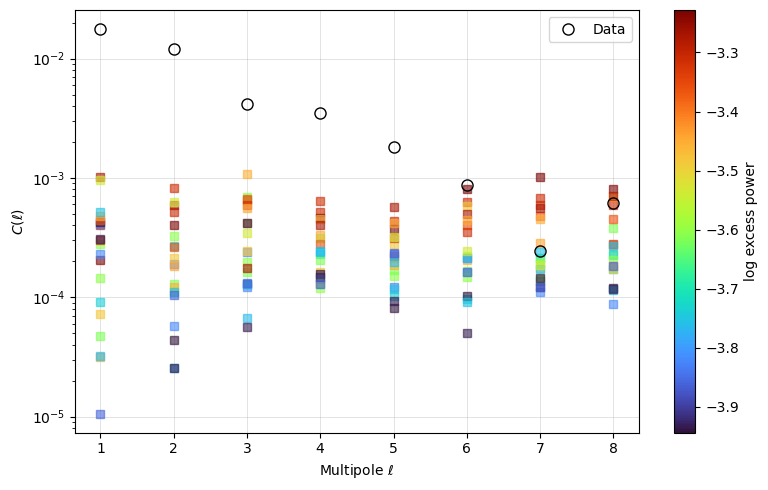

In [146]:
# plot
fig, ax = plt.subplots(figsize=(8,5), tight_layout=True)

norm = mpl.colors.Normalize(min(log_excess), max(log_excess))
smap = mpl.cm.ScalarMappable(norm=norm, cmap='turbo')

# mocks
for i in range(ntocalc):
    ax.plot(ells[1:], Cells[i][1:], marker='s', ls='None', alpha=0.6, c=smap.to_rgba(log_excess[i]))
# data
ax.plot(res_data['ells'][1:], res_data['Cells'][1:], c='None', marker='o', mec='k', ms=8, label='Data')

ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel(r'Multipole $\ell$')
ax.set_ylabel(r'$C(\ell)$')
ax.legend()
ax.semilogy()
fig.colorbar(smap, ax=ax, label='log excess power')